**Questions of Interest**

- We have limited data on these merchants and their transactions, but we are still interested in understanding their payments activity to try to infer the types of merchants using our payment service. Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.


- Sometimes a merchant may stop processing with our payment service, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

# Question 1: Assignments for Each Merchant


## Applying RFM Framework for merchant assignment

In this project, I would like to treat the first question as a customer segmentation problem. Based on such, I have applied the RFM framework to solve it. RFM measures a customer's (merchant's) value in three perspectives, which are:

- Recency: when is the last time the merchant has a transaction 
- Frequency: how many times of transactions does the merchant have during the 2-year timeframe
- Monetary: what is the sum of the transaction amounts in USD from the merchant throughout its lifetime

We will then base on the part of the delivery in question 1 to solve question 2. 

In [258]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
# Globally, we'll make the font size larger for increased readability:
%config InlineBackend.figure_format = 'retina' # Optional - best for macs
plt.rcParams.update({'font.size': 14})

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc, log_loss, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

from tqdm import tqdm

In [23]:
df = pd.read_csv("./takehome_ds_written.csv")
df = df.iloc[:, 1:]
df.head()

,merchant,time,amount_usd_in_cents
0,faa029c6b0,2034-06-17 23:34:14,6349
1,ed7a7d91aa,2034-12-27 00:40:38,3854
2,5608f200cf,2034-04-30 01:29:42,789
3,15b1a0d61e,2034-09-16 01:06:23,4452
4,4770051790,2034-07-22 16:21:42,20203


In [24]:
# check variable type and if there's missing data
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   merchant             1513719 non-null  object
 1   time                 1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 34.6+ MB


merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

In [25]:
# consider day as the smallest unit
df['time'] = df['time'].apply(lambda x: x.split(' ')[0])
df['time'].head()

0    2034-06-17
1    2034-12-27
2    2034-04-30
3    2034-09-16
4    2034-07-22
Name: time, dtype: object

In [26]:
# transform to timestamp
df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   merchant             1513719 non-null  object        
 1   time                 1513719 non-null  datetime64[ns]
 2   amount_usd_in_cents  1513719 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 34.6+ MB


### Transform the dataset through "Merchant" point of view and apply RFM model

In [27]:
# till here
# Aggregate at merchant level

df_mcht = pd.DataFrame(df.pivot_table(index = 'merchant', 
                                      values = ['time', 'amount_usd_in_cents'],
                                      aggfunc = {"time": [min, max, pd.Series.nunique], "amount_usd_in_cents": sum}))
df_mcht.head()             

amount_usd_in_cents       time                   
                           sum        max        min nunique
merchant                                                    
0002b63b92                3379 2033-05-16 2033-05-16       1
0002d07bba               89278 2034-12-15 2034-10-11       4
00057d4302               29521 2033-08-04 2033-05-30       2
000bcff341                7826 2033-08-09 2033-08-09       1
000ddbf0ca               10299 2033-06-02 2033-06-02       1

In [28]:
df_test = df.groupby('merchant').agg({'amount_usd_in_cents':"sum", 'time': ['max', 'min', 'nunique']})
df_test.head()

amount_usd_in_cents       time                   
                           sum        max        min nunique
merchant                                                    
0002b63b92                3379 2033-05-16 2033-05-16       1
0002d07bba               89278 2034-12-15 2034-10-11       4
00057d4302               29521 2033-08-04 2033-05-30       2
000bcff341                7826 2033-08-09 2033-08-09       1
000ddbf0ca               10299 2033-06-02 2033-06-02       1

In [29]:
df_mcht.info()
df.merchant.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 14351 entries, 0002b63b92 to fff1754102
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   (amount_usd_in_cents, sum)  14351 non-null  int64         
 1   (time, max)                 14351 non-null  datetime64[ns]
 2   (time, min)                 14351 non-null  datetime64[ns]
 3   (time, nunique)             14351 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 560.6+ KB


14351

In [30]:
df_mcht.columns = ["MonetaryValue", "LastTransactionDate", "FirstTransactionDate", "Frequency"]
df_mcht.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency
merchant,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1
0002d07bba,89278,2034-12-15,2034-10-11,4
00057d4302,29521,2033-08-04,2033-05-30,2
000bcff341,7826,2033-08-09,2033-08-09,1
000ddbf0ca,10299,2033-06-02,2033-06-02,1


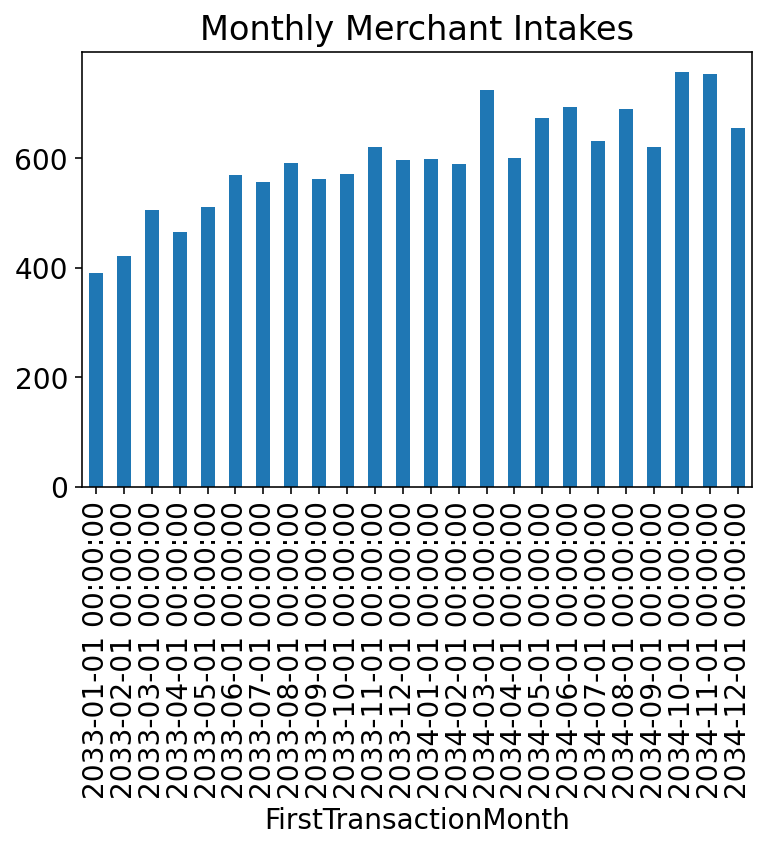

In [31]:
# Create column "FirstTransactionMonth" to look at monthly merchant intake

df_mcht["FirstTransactionMonth"] = df_mcht["FirstTransactionDate"].apply(lambda x: x.replace(day=1))
df_mcht.groupby(["FirstTransactionMonth"]).count()["FirstTransactionDate"].plot(kind="bar")
_ = plt.title("Monthly Merchant Intakes")

In [32]:
# Calculate recency, relative recency and relative frequency
# Take the maximum invoice date as today
today = df_mcht["LastTransactionDate"].max()
today

Timestamp('2034-12-31 00:00:00')

#### Recency Calculation

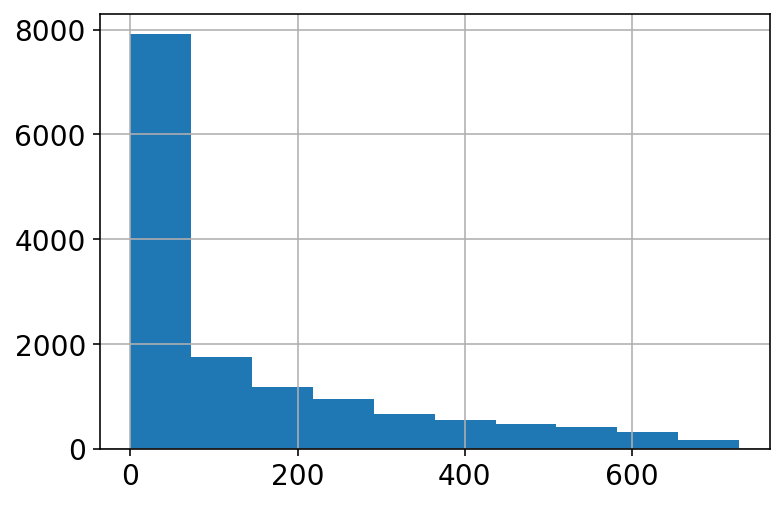

In [33]:
# Calculate recency: the interval (days) between the last transation day and today

df_mcht['Recency'] = (today - df_mcht['LastTransactionDate']) / np.timedelta64(1, 'D')
_ = df_mcht['Recency'].hist()

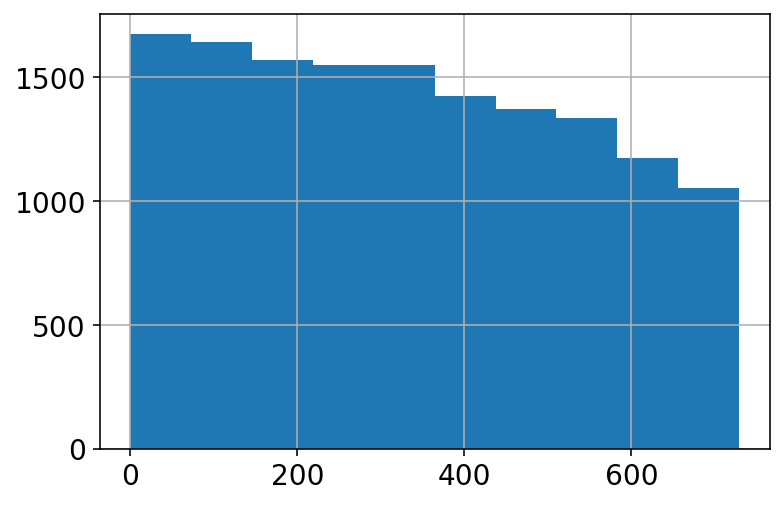

In [34]:
# Calculate customer lifetime: the interval (days) between the first transation day and today

df_mcht['Lifetime'] = (today - df_mcht['FirstTransactionDate']) / np.timedelta64(1, 'D')
_ = df_mcht['Lifetime'].hist() 

In [35]:
df_mcht.Lifetime.describe()

count    14351.000000
mean       336.881054
std        205.578134
min          0.000000
25%        158.000000
50%        325.000000
75%        509.000000
max        729.000000
Name: Lifetime, dtype: float64

**Highlight**

A major different with the general RFM model is that I applied relative recency/frequency/monetary as the metrics which has the original calculated recency/frequency/monetary divided by the lifetime. I think that make more sense for our segmentation, e.g., comparing with a merchant who had its first transaction 1 week ago disappearing in our record for 10 days, the merchant who disappears for the same length of time but whose first transaction is 1 year ago is considered a higher value merchant. 

In [36]:
# this is to adjust the definition of Lifetime so that if first transaction and last transaction happen on 
# the same day, we won't treat the lifetime as 0 to result in nan in the following calculation.

df_mcht.loc[df_mcht["Lifetime"] == 0, 'Lifetime'] = 0.5

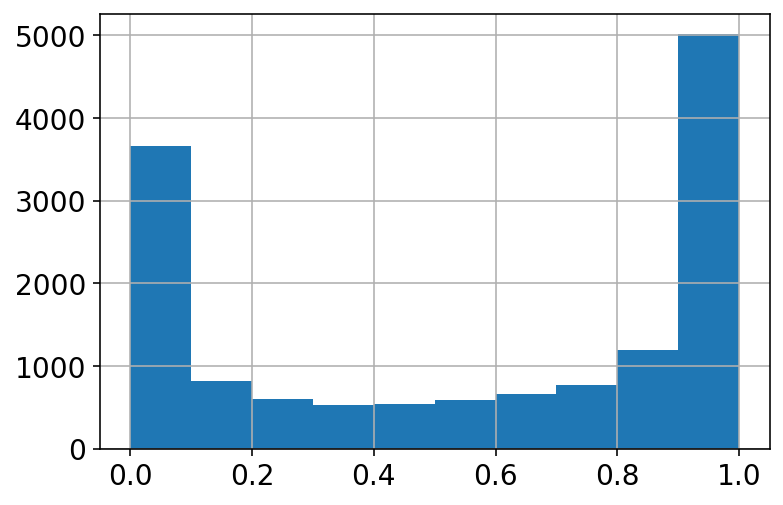

In [37]:
# Calculate the relative recency: recency / customer lifetime

df_mcht["RelRecency"] = 1 - df_mcht["Recency"] / df_mcht["Lifetime"]
_ = df_mcht["RelRecency"].hist()

In [38]:
df_mcht["Recency"].describe()

count    14351.000000
mean       136.961605
std        174.498650
min          0.000000
25%         10.000000
50%         51.000000
75%        213.000000
max        728.000000
Name: Recency, dtype: float64

In [39]:
df_mcht["RelRecency"].describe()

count    14351.000000
mean         0.556704
std          0.400671
min          0.000000
25%          0.092885
50%          0.675287
75%          0.962025
max          1.000000
Name: RelRecency, dtype: float64

**Updated**

13% (1970/14351) of the merchants only use our payment service in the first day, and leave the service! Even when we not consider the merchants not in the last month, 2034/12, we still found **11%** of them only try the first day and leave!


In [40]:
sum(df_mcht["RelRecency"]==0) / len(df_mcht)

0.13727266392585882

In [55]:
df_mcht[df_mcht["RelRecency"]==0][df_mcht[df_mcht["RelRecency"]==0]['FirstTransactionMonth'] != today.replace(day = 1)]

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency
merchant,,,,,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1,2033-05-01,594.0,594.0,0.0
000bcff341,7826,2033-08-09,2033-08-09,1,2033-08-01,509.0,509.0,0.0
000ddbf0ca,10299,2033-06-02,2033-06-02,1,2033-06-01,577.0,577.0,0.0
001f7b7a4f,6444,2034-03-02,2034-03-02,1,2034-03-01,304.0,304.0,0.0
006ec5f506,15222,2034-09-05,2034-09-05,1,2034-09-01,117.0,117.0,0.0
...,...,...,...,...,...,...,...,...
ff026536cf,41804,2033-11-27,2033-11-27,1,2033-11-01,399.0,399.0,0.0
ff0c1adfdd,33922,2034-02-06,2034-02-06,1,2034-02-01,328.0,328.0,0.0
ff9135ed50,18824,2034-11-30,2034-11-30,1,2034-11-01,31.0,31.0,0.0


In [57]:
df_mcht[df_mcht["RelRecency"]==0][df_mcht[df_mcht["RelRecency"]==0]['FirstTransactionMonth'] == today.replace(day = 1)]

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency
merchant,,,,,,,,
00607c6461,50094,2034-12-21,2034-12-21,1,2034-12-01,10.0,10.0,0.0
00858752bc,6775,2034-12-14,2034-12-14,1,2034-12-01,17.0,17.0,0.0
00ef1ec165,752,2034-12-06,2034-12-06,1,2034-12-01,25.0,25.0,0.0
0132448769,29547,2034-12-20,2034-12-20,1,2034-12-01,11.0,11.0,0.0
0135d92658,16326,2034-12-24,2034-12-24,1,2034-12-01,7.0,7.0,0.0
...,...,...,...,...,...,...,...,...
fb71f63be7,71269,2034-12-06,2034-12-06,1,2034-12-01,25.0,25.0,0.0
fcca5ffb03,1963,2034-12-28,2034-12-28,1,2034-12-01,3.0,3.0,0.0
fe761a32a7,7532,2034-12-27,2034-12-27,1,2034-12-01,4.0,4.0,0.0


#### Frequency Calculation

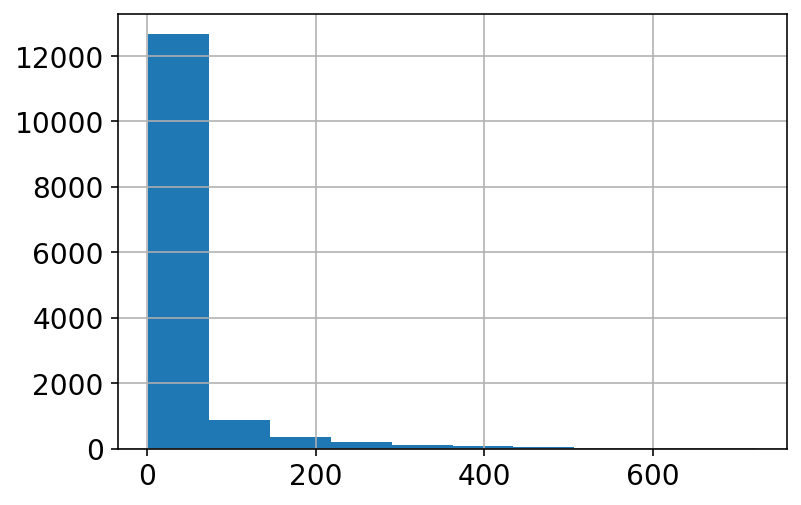

In [61]:
_ = df_mcht["Frequency"].hist()

In [64]:
# Note: through normalization with the lifetime, we could adjust the situation that newer customers tend to 
# have lower lifetime and this lower frequency. 

df_mcht["RelFrequency"] = df_mcht["Frequency"] / df_mcht["Lifetime"]
df_mcht["RelFrequency"].apply(lambda x: np.isinf(x)).value_counts() # shall not be needed now as Liftetime can't be 0 now

False    14351
Name: RelFrequency, dtype: int64

In [65]:
df_mcht["RelFrequency"].describe()

count    14351.000000
mean         0.106793
std          0.179209
min          0.001374
25%          0.012069
50%          0.035088
75%          0.108489
max          2.000000
Name: RelFrequency, dtype: float64

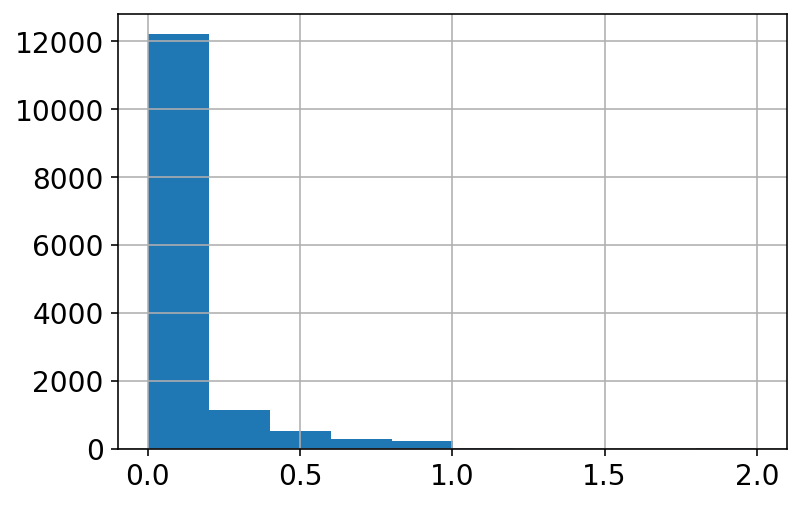

In [66]:
_ = df_mcht["RelFrequency"].hist()

#### Monertary Calculation

In [67]:
df_mcht["MonetaryValue"].describe()

count    1.435100e+04
mean     1.633296e+06
std      6.431726e+06
min      2.010000e+02
25%      3.626300e+04
50%      1.602620e+05
75%      8.230995e+05
max      2.369072e+08
Name: MonetaryValue, dtype: float64

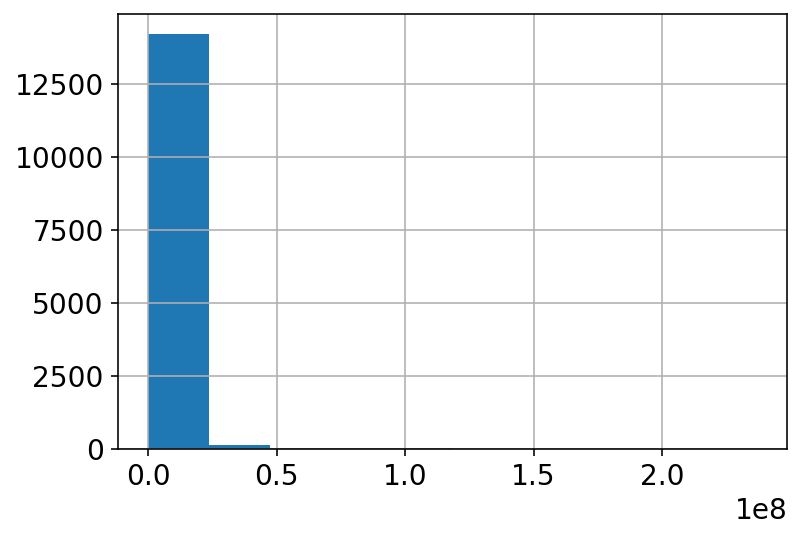

In [68]:
_ = df_mcht["MonetaryValue"].hist()

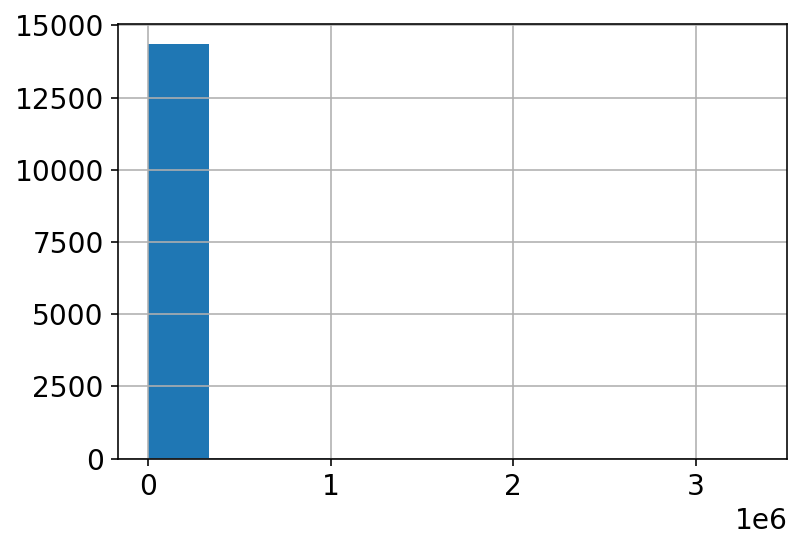

In [69]:
df_mcht["RelMonetaryValue"] = df_mcht["MonetaryValue"] / df_mcht["Lifetime"]
_ = df_mcht["RelMonetaryValue"].hist()

In [70]:
df_mcht["RelMonetaryValue"].describe()

count    1.435100e+04
mean     5.569583e+03
std      3.568936e+04
min      3.452915e-01
25%      1.690238e+02
50%      7.140325e+02
75%      3.192939e+03
max      3.336722e+06
Name: RelMonetaryValue, dtype: float64

### Calculating RFM Score Using Relative Metrics

Through standardized RFM process, I applied 25%, 50%, 75% percentiles to classify each metric, R, F, and M, into 4 levels, 1, 2, 3, and 4 accordingly. After summing the scores for each metric, I will have each merchant being leveled from 3 to 12, totally 10 groups. 

In [72]:
df_mcht["RelRecencyScore"] = pd.cut(df_mcht["RelRecency"], 
                               bins=[-1, 
                                     np.percentile(df_mcht["RelRecency"], 25), 
                                     np.percentile(df_mcht["RelRecency"], 50), 
                                     np.percentile(df_mcht["RelRecency"], 75), 
                                     df_mcht["RelRecency"].max()], 
                               labels=[1, 2, 3, 4]).astype("int")
df_mcht["RelRecencyScore"].value_counts()

1    3588
3    3588
2    3588
4    3587
Name: RelRecencyScore, dtype: int64

In [73]:
df_mcht["RelFrequencyScore"] = pd.cut(df_mcht["RelFrequency"], 
                                       bins=[-1, 
                                             np.percentile(df_mcht["RelFrequency"], 25), 
                                             np.percentile(df_mcht["RelFrequency"], 50), 
                                             np.percentile(df_mcht["RelFrequency"], 75), 
                                             df_mcht["RelFrequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
df_mcht["RelFrequencyScore"].value_counts()

2    3595
1    3589
4    3588
3    3579
Name: RelFrequencyScore, dtype: int64

In [74]:
df_mcht["RelMonetaryScore"] = pd.cut(df_mcht["RelMonetaryValue"], 
                                       bins=[df_mcht["RelMonetaryValue"].min()-1, 
                                             np.percentile(df_mcht["RelMonetaryValue"], 25),
                                             np.percentile(df_mcht["RelMonetaryValue"], 50), 
                                             np.percentile(df_mcht["RelMonetaryValue"], 75), 
                                             df_mcht["RelMonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
df_mcht["RelMonetaryScore"].value_counts()

1    3588
4    3588
2    3588
3    3587
Name: RelMonetaryScore, dtype: int64

In [75]:
df_mcht.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RelRecencyScore,RelFrequencyScore,RelMonetaryScore
merchant,,,,,,,,,,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,1,1,1
0002d07bba,89278,2034-12-15,2034-10-11,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,3,3,3
00057d4302,29521,2033-08-04,2033-05-30,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,2,1,1
000bcff341,7826,2033-08-09,2033-08-09,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,1,1,1
000ddbf0ca,10299,2033-06-02,2033-06-02,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,1,1,1


In [76]:
df_mcht["RelRFM"] = df_mcht["RelRecencyScore"] + df_mcht["RelFrequencyScore"] + df_mcht["RelMonetaryScore"]
df_mcht["RelRFM"].value_counts()

12    1645
7     1543
3     1517
8     1491
5     1461
9     1452
6     1380
10    1322
4     1316
11    1224
Name: RelRFM, dtype: int64

In [80]:
df_rfm_rel = pd.DataFrame(df_mcht.pivot_table(index=["RelRFM"], 
                                    values=["RelRecency", "RelFrequency", "RelMonetaryValue", "Lifetime"], 
                                    aggfunc={"RelRecency": [np.min, np.median, np.max], 
                                             "RelFrequency": [np.min, np.median, np.max], 
                                             "RelMonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
df_rfm_rel

Lifetime                    RelFrequency                      \
           amax  amin count median         amax      amin    median   
RelRFM                                                                
3         729.0  83.0  1517  400.0     0.012048  0.001374  0.004243   
4         729.0  29.0  1316  354.0     0.034483  0.001381  0.007624   
5         726.0  12.0  1461  329.0     0.083333  0.001477  0.013761   
6         727.0   3.0  1380  305.0     0.333333  0.001449  0.019851   
7         724.0   1.0  1543  272.0     1.000000  0.003731  0.030875   
8         725.0   2.0  1491  277.0     0.500000  0.003257  0.044521   
9         729.0   1.0  1452  285.0     1.000000  0.003472  0.064994   
10        729.0   2.0  1322  304.0     1.000000  0.012245  0.100327   
11        729.0   4.0  1224  318.0     1.000000  0.035545  0.170706   
12        729.0   0.5  1645  386.0     2.000000  0.108696  0.397380   

       RelMonetaryValue                            RelRecency            \
                   amax         amin        median       amax      amin   
RelRFM                                                                    
3          1.689189e+02     0.345291     48.140870   0.092275  0.000000   
4          7.075513e+02     2.841463    110.137013   0.675127  0.000000   
5          3.158374e+03     7.283912    177.425926   0.961625  0.000000   
6          1.764552e+04     2.613487    298.354689   1.000000  0.000000   
7          2.982334e+05    18.075000    500.657407   1.000000  0.000000   
8          1.623950e+05    24.101299    845.630841   1.000000  0.000000   
9          4.079245e+05    87.371166   1506.067656   1.000000  0.000000   
10         5.279682e+05   196.990329   2463.481599   1.000000  0.100000   
11         3.336722e+06   715.734375   3969.554665   1.000000  0.675595   
12         8.114468e+05  3194.124514  11422.015385   1.000000  0.962085   

                  
          median  
RelRFM            
3       0.000000  
4       0.056578  
5       0.172084  
6       0.369213  
7       0.548673  
8       0.766667  
9       0.869736  
10      0.934237  
11      0.977839  
12      0.995918

In [84]:
df_rfm_rel_test = df_mcht.groupby("RelRFM").aggregate({
                                    "Lifetime": ["max", "min", "count", "median"], 
                                    "RelFrequency": ["max", "min", "median"],
                                    "RelMonetaryValue": ["max", "min", "median"],
                                    "RelRecency": ["max", "min", "median"],    
                                    })
df_rfm_rel_test

Lifetime                    RelFrequency                      \
            max   min count median          max       min    median   
RelRFM                                                                
3         729.0  83.0  1517  400.0     0.012048  0.001374  0.004243   
4         729.0  29.0  1316  354.0     0.034483  0.001381  0.007624   
5         726.0  12.0  1461  329.0     0.083333  0.001477  0.013761   
6         727.0   3.0  1380  305.0     0.333333  0.001449  0.019851   
7         724.0   1.0  1543  272.0     1.000000  0.003731  0.030875   
8         725.0   2.0  1491  277.0     0.500000  0.003257  0.044521   
9         729.0   1.0  1452  285.0     1.000000  0.003472  0.064994   
10        729.0   2.0  1322  304.0     1.000000  0.012245  0.100327   
11        729.0   4.0  1224  318.0     1.000000  0.035545  0.170706   
12        729.0   0.5  1645  386.0     2.000000  0.108696  0.397380   

       RelMonetaryValue                            RelRecency            \
                    max          min        median        max       min   
RelRFM                                                                    
3          1.689189e+02     0.345291     48.140870   0.092275  0.000000   
4          7.075513e+02     2.841463    110.137013   0.675127  0.000000   
5          3.158374e+03     7.283912    177.425926   0.961625  0.000000   
6          1.764552e+04     2.613487    298.354689   1.000000  0.000000   
7          2.982334e+05    18.075000    500.657407   1.000000  0.000000   
8          1.623950e+05    24.101299    845.630841   1.000000  0.000000   
9          4.079245e+05    87.371166   1506.067656   1.000000  0.000000   
10         5.279682e+05   196.990329   2463.481599   1.000000  0.100000   
11         3.336722e+06   715.734375   3969.554665   1.000000  0.675595   
12         8.114468e+05  3194.124514  11422.015385   1.000000  0.962085   

                  
          median  
RelRFM            
3       0.000000  
4       0.056578  
5       0.172084  
6       0.369213  
7       0.548673  
8       0.766667  
9       0.869736  
10      0.934237  
11      0.977839  
12      0.995918

**Update**

Based on above chart, we could statistically summarize the first-half the user score, RelRFM from 8 ~ 12, has the below characteristics: 

- Use the service once every two days
- Spend average $8 dollars per day
- has not left the service for more than 1 quarter (25%) of his service lifetime

**Highlight**

Note that based on the above table and below chart, the 50 percentile (median) lifetime is rather relatively across clusters. This is a good news - our segmentation is not biased by the lifetime of the merchant.

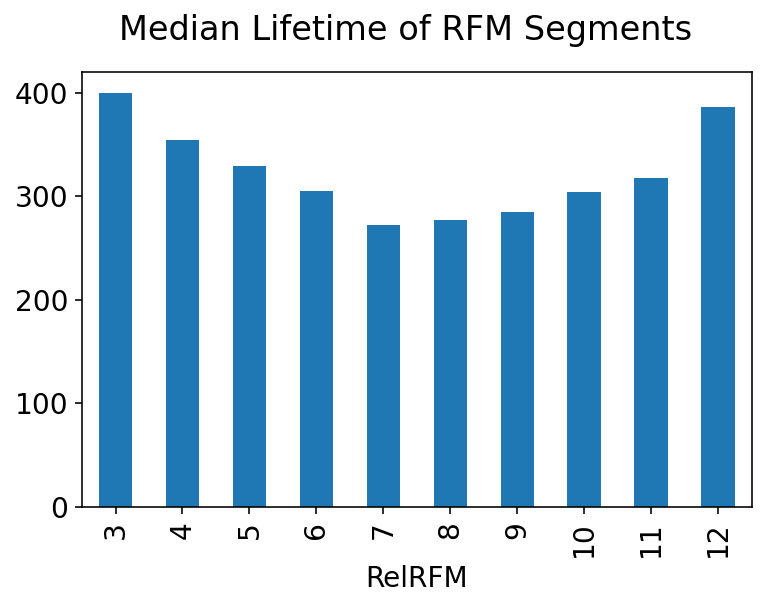

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Median Lifetime of RFM Segments')
df_rfm_rel["Lifetime"]["median"].plot(kind="bar")
plt.show()

/var/folders/2t/5fzjt2x13h329_bxg11ttqzh0000gn/T/ipykernel_5479/3075319709.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


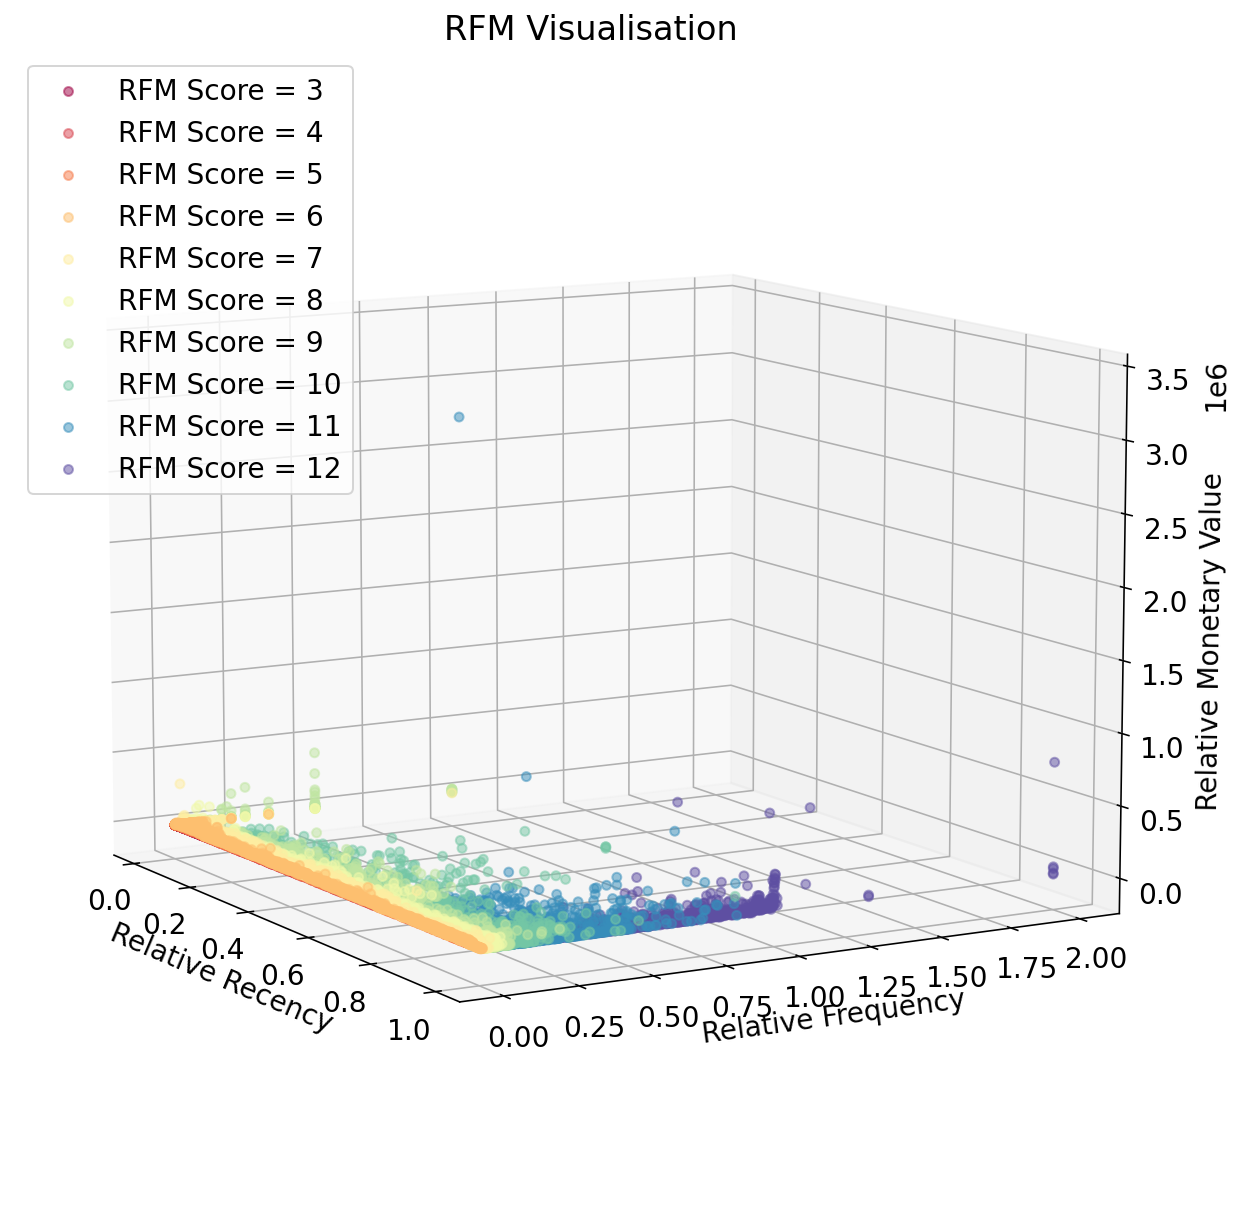

In [87]:
# Visualise segments using 3D plot

colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(df_mcht["RelRFM"])))) # spectral color map divided into K colors

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax = Axes3D(fig)

for ii in range(0,360,1):
    ax.view_init(elev=10., azim=-30)

for score in np.unique(df_mcht["RelRFM"]):
    RFM_member = (df_mcht["RelRFM"] == score)
    ax.scatter(df_mcht.loc[RFM_member, "RelRecency"], 
               df_mcht.loc[RFM_member, "RelFrequency"], 
               df_mcht.loc[RFM_member, "RelMonetaryValue"], 
               color = colors[score-3], label= "RFM Score = {0}".format(score), s=20, alpha=0.5)

ax.set_title("RFM Visualisation")
ax.set_xlabel("Relative Recency")
ax.set_ylabel("Relative Frequency")
ax.set_zlabel("Relative Monetary Value")
plt.legend(loc = "upper left")
plt.show()

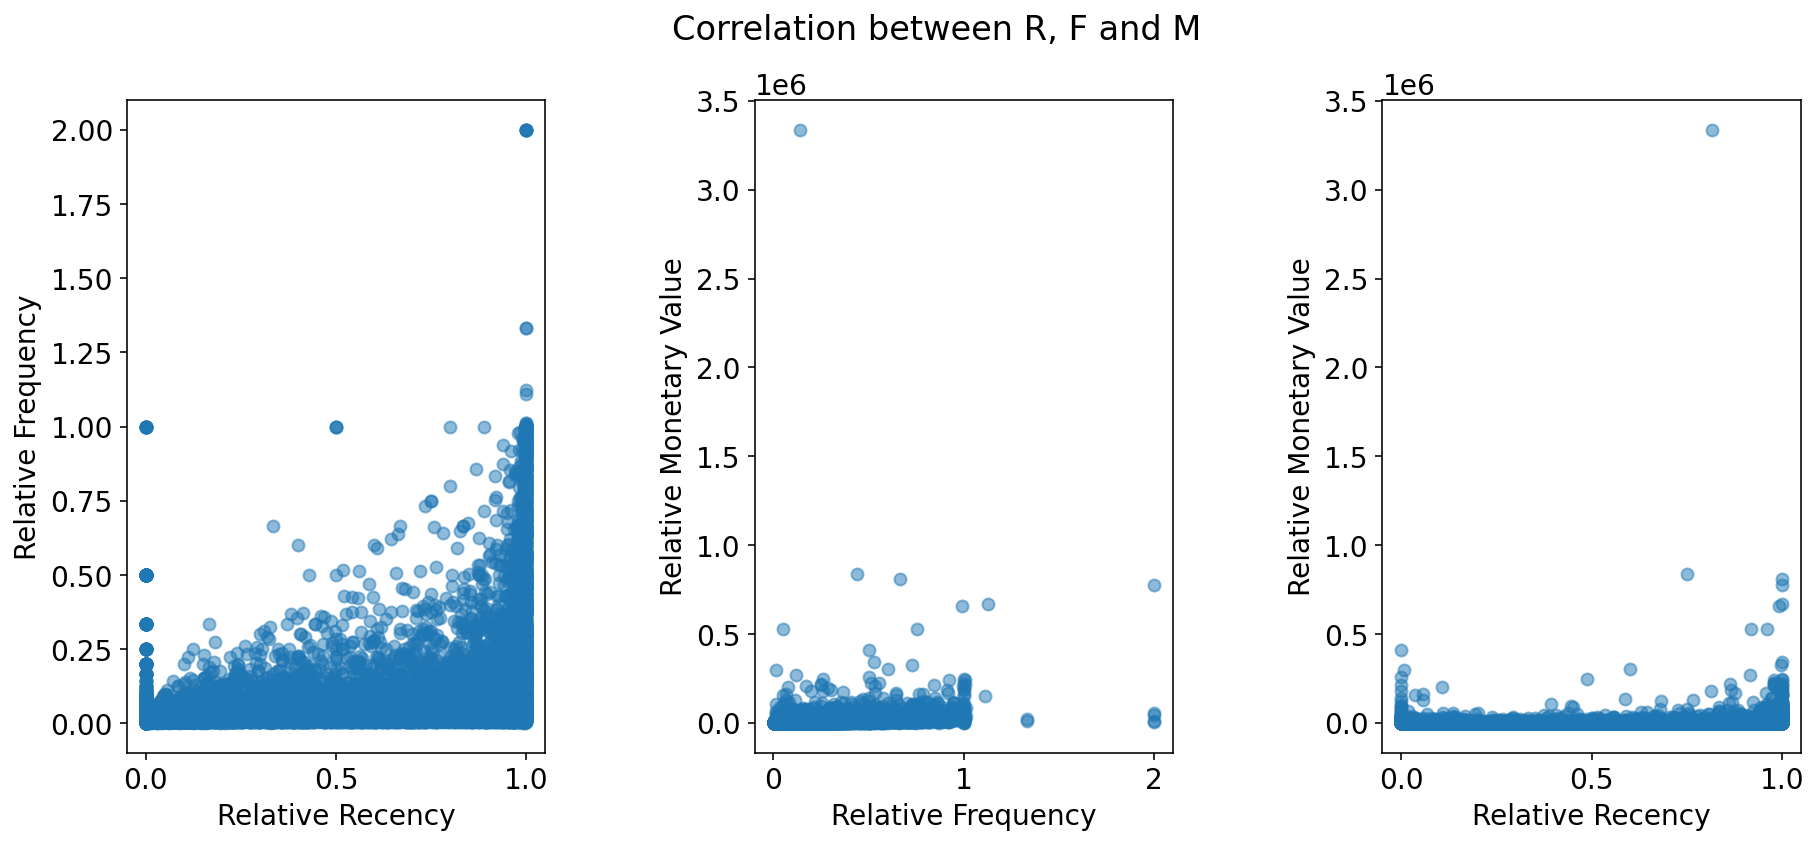

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.5)

fig.suptitle('Correlation between R, F and M')

axs[0].scatter(df_mcht["RelRecency"], df_mcht["RelFrequency"], alpha=0.5)
# axs[0].set_title("Relative Recency (x) vs Relative Frequency (y)")
axs[0].set_xlabel("Relative Recency")
axs[0].set_ylabel("Relative Frequency")

axs[1].scatter(df_mcht["RelFrequency"], df_mcht["RelMonetaryValue"], alpha=0.5)
# axs[1].set_title("Relative Frequency (x) vs Relative Monetary Value (y)")
axs[1].set_xlabel("Relative Frequency")
axs[1].set_ylabel("Relative Monetary Value")

axs[2].scatter(df_mcht["RelRecency"], df_mcht["RelMonetaryValue"], alpha=0.5)
# axs[2].set_title("Relative Recency (x) vs Relative Monetary Value (y)")
axs[2].set_xlabel("Relative Recency")
axs[2].set_ylabel("Relative Monetary Value")

plt.show()

/var/folders/2t/5fzjt2x13h329_bxg11ttqzh0000gn/T/ipykernel_5479/4091380628.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


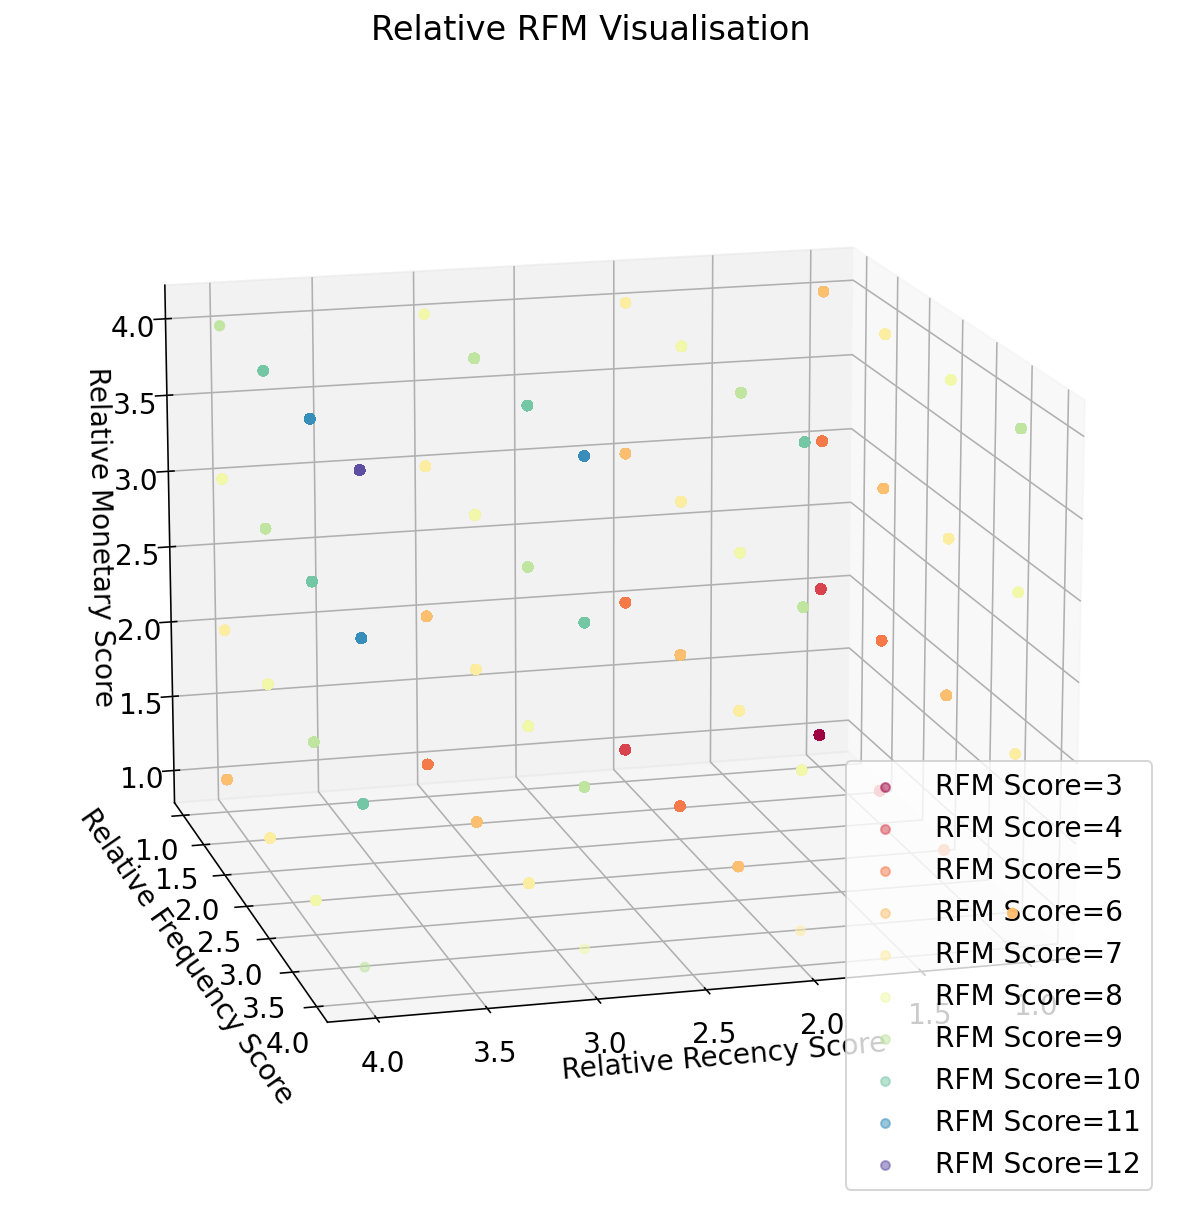

In [91]:
x = df_mcht["RelRecencyScore"]
y = df_mcht["RelFrequencyScore"]
z = df_mcht["RelMonetaryScore"]
colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(df_mcht["RelRFM"])))) # spectral color map divided into K colors

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax = Axes3D(fig)

for ii in range(0,360,1):
    ax.view_init(elev=15., azim=75)

for score in np.unique(df_mcht["RelRFM"]):
    RFM_member = (df_mcht["RelRFM"] == score)
    ax.scatter(df_mcht.loc[RFM_member, "RelRecencyScore"], 
               df_mcht.loc[RFM_member, "RelFrequencyScore"], 
               df_mcht.loc[RFM_member, "RelMonetaryScore"], 
               color = colors[score-3], label= "RFM Score={0}".format(score), s=20, alpha=0.5)

ax.set_title("Relative RFM Visualisation")
ax.set_xlabel("Relative Recency Score")
ax.set_ylabel("Relative Frequency Score")
ax.set_zlabel("Relative Monetary Score")
plt.legend(loc = "lower right")
plt.show()

### Generate simple criteria for labelling

So far, there are 10 groups of merchants defined by the RFM score. I would like to add some heuristic rules which considering product user growth to simplify the segmentation to 4 groups.

In [92]:
df_rfm_rel

Lifetime                    RelFrequency                      \
           amax  amin count median         amax      amin    median   
RelRFM                                                                
3         729.0  83.0  1517  400.0     0.012048  0.001374  0.004243   
4         729.0  29.0  1316  354.0     0.034483  0.001381  0.007624   
5         726.0  12.0  1461  329.0     0.083333  0.001477  0.013761   
6         727.0   3.0  1380  305.0     0.333333  0.001449  0.019851   
7         724.0   1.0  1543  272.0     1.000000  0.003731  0.030875   
8         725.0   2.0  1491  277.0     0.500000  0.003257  0.044521   
9         729.0   1.0  1452  285.0     1.000000  0.003472  0.064994   
10        729.0   2.0  1322  304.0     1.000000  0.012245  0.100327   
11        729.0   4.0  1224  318.0     1.000000  0.035545  0.170706   
12        729.0   0.5  1645  386.0     2.000000  0.108696  0.397380   

       RelMonetaryValue                            RelRecency            \
                   amax         amin        median       amax      amin   
RelRFM                                                                    
3          1.689189e+02     0.345291     48.140870   0.092275  0.000000   
4          7.075513e+02     2.841463    110.137013   0.675127  0.000000   
5          3.158374e+03     7.283912    177.425926   0.961625  0.000000   
6          1.764552e+04     2.613487    298.354689   1.000000  0.000000   
7          2.982334e+05    18.075000    500.657407   1.000000  0.000000   
8          1.623950e+05    24.101299    845.630841   1.000000  0.000000   
9          4.079245e+05    87.371166   1506.067656   1.000000  0.000000   
10         5.279682e+05   196.990329   2463.481599   1.000000  0.100000   
11         3.336722e+06   715.734375   3969.554665   1.000000  0.675595   
12         8.114468e+05  3194.124514  11422.015385   1.000000  0.962085   

                  
          median  
RelRFM            
3       0.000000  
4       0.056578  
5       0.172084  
6       0.369213  
7       0.548673  
8       0.766667  
9       0.869736  
10      0.934237  
11      0.977839  
12      0.995918

In [93]:
df_mcht

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RelRecencyScore,RelFrequencyScore,RelMonetaryScore,RelRFM
merchant,,,,,,,,,,,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,1,1,1,3
0002d07bba,89278,2034-12-15,2034-10-11,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,3,3,3,9
00057d4302,29521,2033-08-04,2033-05-30,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,2,1,1,4
000bcff341,7826,2033-08-09,2033-08-09,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,1,1,1,3
000ddbf0ca,10299,2033-06-02,2033-06-02,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd3e45675,72626,2033-01-27,2033-01-04,5,2033-01-01,703.0,726.0,0.031680,0.006887,100.035813,1,1,1,3
ffe1f6b51a,281616,2034-02-19,2033-06-04,47,2033-06-01,315.0,575.0,0.452174,0.081739,489.766957,2,3,2,7
ffe26b900d,959113,2034-11-21,2033-12-22,66,2033-12-01,40.0,374.0,0.893048,0.176471,2564.473262,3,4,3,10


**Highlight**

Our rules for segmentation is that:

- Transaction relative frequency (transaction times divided by the lifetime of the merchant) equals to 0.035, which is the gap between relative frequency score 2 and 3. 
- Transaction relative monetary (sum of the transactions divided by the lifetime of the merchant) equals to 700, which is the gap between relative monetary score 2 and 3. 
- Transaction relative recency (day difference between the last time transaction and today divided by the lifetime of the merchant) equals to 0.67, which is the gap between relative monetary score 2 and 3. 

**Update**

Why pick such classification?

It depends on the business needs and the context of how we apply the analysis. Without the details of these, we consider **the behaviors at the median score of each of the 3 metrics as a guideline/baseline** for us to evaluate the behaviors across layers. 

However, it doesn't have to base on the RFM scores. If we would like to consider high value users as people who spend more than 100 USD per day, we could directly apply *RelMonetaryValue* to set the condition of classification.

In brief, it all depends on business context. 

In [111]:
print(df_mcht.RelRecency.describe(), "\n")
print(df_mcht.RelFrequency.describe(), "\n") 
print(df_mcht.RelMonetaryValue.describe(), "\n")

count    14351.000000
mean         0.556704
std          0.400671
min          0.000000
25%          0.092885
50%          0.675287
75%          0.962025
max          1.000000
Name: RelRecency, dtype: float64 

count    14351.000000
mean         0.106793
std          0.179209
min          0.001374
25%          0.012069
50%          0.035088
75%          0.108489
max          2.000000
Name: RelFrequency, dtype: float64 

count    1.435100e+04
mean     5.569583e+03
std      3.568936e+04
min      3.452915e-01
25%      1.690238e+02
50%      7.140325e+02
75%      3.192939e+03
max      3.336722e+06
Name: RelMonetaryValue, dtype: float64 



In [104]:
df_mcht["order_more_than_3_5pcnt"] = df_mcht["RelFrequencyScore"] >= 3 
df_mcht["value_higher_than_700"] = df_mcht["RelMonetaryScore"] >= 3 
df_mcht["last_order_within_2_3"] = df_mcht["RelRecencyScore"] >= 3 

df_mcht.groupby(["order_more_than_3_5pcnt", "value_higher_than_700", "last_order_within_2_3"]).count()["Lifetime"]

order_more_than_3_5pcnt  value_higher_than_700  last_order_within_2_3
False                    False                  False                    4318
                                                True                     1306
                         True                   False                     938
                                                True                      622
True                     False                  False                     696
                                                True                      856
                         True                   False                    1224
                                                True                     4391
Name: Lifetime, dtype: int64

In [110]:
sum(df_mcht['RelRecencyScore'] >=3)

7175

In [112]:
conditions = [
    (df_mcht["order_more_than_3_5pcnt"]==True)&(df_mcht["value_higher_than_700"]==True),
    (df_mcht["order_more_than_3_5pcnt"]==True)&(df_mcht["value_higher_than_700"]==False),
    (df_mcht["order_more_than_3_5pcnt"]==False)&((df_mcht["value_higher_than_700"]==True)|(df_mcht["last_order_within_2_3"]==True)),
    (df_mcht["order_more_than_3_5pcnt"]==False)&(df_mcht["value_higher_than_700"]==False)&(df_mcht["last_order_within_2_3"]==False)
]
mappings = ["01. high engagement and high value", 
            "02. high engagement and low value", 
            "03. low engagement but high value or recent usage", 
            "04. potential churn"]
df_mcht['FinalRFM'] = np.select(conditions, mappings, default="Others")
df_mcht['FinalRFM'].value_counts()

01. high engagement and high value                   5615
04. potential churn                                  4318
03. low engagement but high value or recent usage    2866
02. high engagement and low value                    1552
Name: FinalRFM, dtype: int64

**Identifications of the 4 Merchant Assignment**

1. MVC
2. Loyal customers
3. Potential MVC or loyal customer
4. Potential churn

In [113]:
df_mcht.pivot_table(index=["FinalRFM"], 
                  values=["RelRecency", "RelFrequency", "RelMonetaryValue", "Lifetime"], 
                  aggfunc={"RelRecency": [np.min, np.median, np.max], 
                           "RelFrequency": [np.min, np.median, np.max], 
                           "RelMonetaryValue": [np.min, np.median, np.max], 
                           "Lifetime": [np.min, np.median, np.max, "count"]})

Lifetime                     \
                                                      amax  amin count median   
FinalRFM                                                                        
01. high engagement and high value                   729.0   0.5  5615  293.0   
02. high engagement and low value                    726.0   1.0  1552  221.0   
03. low engagement but high value or recent usage    727.0  29.0  2866  397.0   
04. potential churn                                  729.0  29.0  4318  351.0   

                                                  RelFrequency            \
                                                          amax      amin   
FinalRFM                                                                   
01. high engagement and high value                    2.000000  0.035156   
02. high engagement and low value                     1.000000  0.035120   
03. low engagement but high value or recent usage     0.035088  0.001449   
04. potential churn                                   0.035088  0.001374   

                                                            RelMonetaryValue  \
                                                     median             amax   
FinalRFM                                                                       
01. high engagement and high value                 0.144970     3.336722e+06   
02. high engagement and low value                  0.054545     7.139883e+02   
03. low engagement but high value or recent usage  0.018127     2.982334e+05   
04. potential churn                                0.008621     7.129531e+02   

                                                                            \
                                                         amin       median   
FinalRFM                                                                     
01. high engagement and high value                 714.400000  3868.340708   
02. high engagement and low value                   10.578947   393.126844   
03. low engagement but high value or recent usage    2.613487   808.005223   
04. potential churn                                  0.345291   105.640058   

                                                  RelRecency                 
                                                        amax amin    median  
FinalRFM                                                                     
01. high engagement and high value                  1.000000  0.0  0.962585  
02. high engagement and low value                   1.000000  0.0  0.744213  
03. low engagement but high value or recent usage   1.000000  0.0  0.794955  
04. potential churn                                 0.675127  0.0  0.043160

In [115]:
df_mcht.groupby("FinalRFM").aggregate({
                                        "RelRecency": 'median',
                                        "RelFrequency": 'median',
                                        "RelMonetaryValue": 'median',
                                        "Lifetime": 'median'
})

,RelRecency,RelFrequency,RelMonetaryValue,Lifetime
FinalRFM,,,,
01. high engagement and high value,0.962585,0.144970,3868.340708,293.0
02. high engagement and low value,0.744213,0.054545,393.126844,221.0
03. low engagement but high value or recent usage,0.794955,0.018127,808.005223,397.0
04. potential churn,0.043160,0.008621,105.640058,351.0


In [367]:
sum(df_mcht.RelRFM <= 6)

5674

In [114]:
df.head()

,merchant,time,amount_usd_in_cents
0,faa029c6b0,2034-06-17,6349
1,ed7a7d91aa,2034-12-27,3854
2,5608f200cf,2034-04-30,789
3,15b1a0d61e,2034-09-16,4452
4,4770051790,2034-07-22,20203


**Definition:**

- New users: those who made their first purchase in the current month
- Active users: those who made purchases in the previous month and in the current month
- Inactive users: those who made purchases in previous months, but not in the current month
- Return users: those who made purchases before the previous month, not in the previous month and made purchases agian in the current month

In [121]:
# Calculate the number of new users, inactive users, return users and active users in each month

df["TransactionMonth"] = df["time"].apply(lambda x: x.replace(day=1))
df["TransactionMonth"] = df["TransactionMonth"].apply(lambda x: x.strftime("%Y-%m-%d"))
merchant_month_pivot = df.pivot_table(index=["merchant"], 
                                    columns=["TransactionMonth"], 
                                    values=["time"], 
                                    aggfunc="count", 
                                    fill_value=0)
merchant_month_pivot.head()

time                                              \
TransactionMonth 2033-01-01 2033-02-01 2033-03-01 2033-04-01 2033-05-01   
merchant                                                                  
0002b63b92                0          0          0          0          1   
0002d07bba                0          0          0          0          0   
00057d4302                0          0          0          0         17   
000bcff341                0          0          0          0          0   
000ddbf0ca                0          0          0          0          0   

                                                                         ...  \
TransactionMonth 2033-06-01 2033-07-01 2033-08-01 2033-09-01 2033-10-01  ...   
merchant                                                                 ...   
0002b63b92                0          0          0          0          0  ...   
0002d07bba                0          0          0          0          0  ...   
00057d4302                0          0         11          0          0  ...   
000bcff341                0          0          1          0          0  ...   
000ddbf0ca                1          0          0          0          0  ...   

                                                                         \
TransactionMonth 2034-03-01 2034-04-01 2034-05-01 2034-06-01 2034-07-01   
merchant                                                                  
0002b63b92                0          0          0          0          0   
0002d07bba                0          0          0          0          0   
00057d4302                0          0          0          0          0   
000bcff341                0          0          0          0          0   
000ddbf0ca                0          0          0          0          0   

                                                                         
TransactionMonth 2034-08-01 2034-09-01 2034-10-01 2034-11-01 2034-12-01  
merchant                                                                 
0002b63b92                0          0          0          0          0  
0002d07bba                0          0          2          1          1  
00057d4302                0          0          0          0          0  
000bcff341                0          0          0          0          0  
000ddbf0ca                0          0          0          0          0  

[5 rows x 24 columns]

In [129]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   merchant             1513719 non-null  object        
 1   time                 1513719 non-null  datetime64[ns]
 2   amount_usd_in_cents  1513719 non-null  int64         
 3   TransactionMonth     1513719 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 46.2+ MB


,merchant,time,amount_usd_in_cents,TransactionMonth
0,faa029c6b0,2034-06-17,6349,2034-06-01
1,ed7a7d91aa,2034-12-27,3854,2034-12-01
2,5608f200cf,2034-04-30,789,2034-04-01
3,15b1a0d61e,2034-09-16,4452,2034-09-01
4,4770051790,2034-07-22,20203,2034-07-01
...,...,...,...,...
1513714,72d37bedbf,2034-06-21,5274,2034-06-01
1513715,5608f200cf,2034-04-20,754,2034-04-01
1513716,fcbd1dae68,2033-09-19,13203,2033-09-01
1513717,9843e52410,2034-12-28,4845,2034-12-01


In [138]:
# how to use groupby for above?

In [139]:
# Replace count of invoices with 1
merchant_month_pivot = merchant_month_pivot.applymap(lambda x: 1 if x>0 else 0)
merchant_month_pivot.head()

time                                              \
TransactionMonth 2033-01-01 2033-02-01 2033-03-01 2033-04-01 2033-05-01   
merchant                                                                  
0002b63b92                0          0          0          0          1   
0002d07bba                0          0          0          0          0   
00057d4302                0          0          0          0          1   
000bcff341                0          0          0          0          0   
000ddbf0ca                0          0          0          0          0   

                                                                         ...  \
TransactionMonth 2033-06-01 2033-07-01 2033-08-01 2033-09-01 2033-10-01  ...   
merchant                                                                 ...   
0002b63b92                0          0          0          0          0  ...   
0002d07bba                0          0          0          0          0  ...   
00057d4302                0          0          1          0          0  ...   
000bcff341                0          0          1          0          0  ...   
000ddbf0ca                1          0          0          0          0  ...   

                                                                         \
TransactionMonth 2034-03-01 2034-04-01 2034-05-01 2034-06-01 2034-07-01   
merchant                                                                  
0002b63b92                0          0          0          0          0   
0002d07bba                0          0          0          0          0   
00057d4302                0          0          0          0          0   
000bcff341                0          0          0          0          0   
000ddbf0ca                0          0          0          0          0   

                                                                         
TransactionMonth 2034-08-01 2034-09-01 2034-10-01 2034-11-01 2034-12-01  
merchant                                                                 
0002b63b92                0          0          0          0          0  
0002d07bba                0          0          1          1          1  
00057d4302                0          0          0          0          0  
000bcff341                0          0          0          0          0  
000ddbf0ca                0          0          0          0          0  

[5 rows x 24 columns]

In [140]:
# Get the number of columns
len((merchant_month_pivot).columns)

24

In [141]:
# Define functions to get user status
def user_status(data):
    status = []
    for i in range(24):
    # If the user has no purchase in the current month
        if data[i] == 0:
            # If the user has made purchases before
            if len(status) > 0:
                # If the user is unregistered in the previous month
                if status[i-1] == "unreg":
                # The the user is also unregistered this month
                    status.append("unreg")
                # Otherwise the user is an active user, i.e., he/she already registered
                else:
                    status.append("inactive")
            # Otherwise the user is not registered in the current month, i.e., he/she has never made any purchases
            else:
                status.append("unreg")
        else:
            # This is the first purchase of the user
            if len(status) == 0:
                status.append("new")
            else:
                if status[i-1] == "inactive":
                    status.append("return")
                elif status[i-1] == "unreg":
                    status.append("new")
                else:
                    status.append("active")
    return status

In [142]:
merchant_month_status = pd.DataFrame(merchant_month_pivot.apply(lambda x: pd.Series(user_status(x)), axis=1))
merchant_month_status.columns = merchant_month_pivot.columns
merchant_month_status.head()

time                                              \
TransactionMonth 2033-01-01 2033-02-01 2033-03-01 2033-04-01 2033-05-01   
merchant                                                                  
0002b63b92            unreg      unreg      unreg      unreg        new   
0002d07bba            unreg      unreg      unreg      unreg      unreg   
00057d4302            unreg      unreg      unreg      unreg        new   
000bcff341            unreg      unreg      unreg      unreg      unreg   
000ddbf0ca            unreg      unreg      unreg      unreg      unreg   

                                                                         ...  \
TransactionMonth 2033-06-01 2033-07-01 2033-08-01 2033-09-01 2033-10-01  ...   
merchant                                                                 ...   
0002b63b92         inactive   inactive   inactive   inactive   inactive  ...   
0002d07bba            unreg      unreg      unreg      unreg      unreg  ...   
00057d4302         inactive   inactive     return   inactive   inactive  ...   
000bcff341            unreg      unreg        new   inactive   inactive  ...   
000ddbf0ca              new   inactive   inactive   inactive   inactive  ...   

                                                                         \
TransactionMonth 2034-03-01 2034-04-01 2034-05-01 2034-06-01 2034-07-01   
merchant                                                                  
0002b63b92         inactive   inactive   inactive   inactive   inactive   
0002d07bba            unreg      unreg      unreg      unreg      unreg   
00057d4302         inactive   inactive   inactive   inactive   inactive   
000bcff341         inactive   inactive   inactive   inactive   inactive   
000ddbf0ca         inactive   inactive   inactive   inactive   inactive   

                                                                         
TransactionMonth 2034-08-01 2034-09-01 2034-10-01 2034-11-01 2034-12-01  
merchant                                                                 
0002b63b92         inactive   inactive   inactive   inactive   inactive  
0002d07bba            unreg      unreg        new     active     active  
00057d4302         inactive   inactive   inactive   inactive   inactive  
000bcff341         inactive   inactive   inactive   inactive   inactive  
000ddbf0ca         inactive   inactive   inactive   inactive   inactive  

[5 rows x 24 columns]

In [143]:
month_status_pivot = pd.DataFrame(merchant_month_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x)))
month_status_pivot.head()

time                                              \
TransactionMonth 2033-01-01 2033-02-01 2033-03-01 2033-04-01 2033-05-01   
active                  NaN      235.0        421        630        766   
inactive                NaN      155.0        352        617        890   
new                   390.0      421.0        505        465        511   
return                  NaN        NaN         38         69        125   

                                                                         ...  \
TransactionMonth 2033-06-01 2033-07-01 2033-08-01 2033-09-01 2033-10-01  ...   
active                  922       1128       1303       1480       1662  ...   
inactive               1223       1555       1861       2248       2582  ...   
new                     570        557        591        562        572  ...   
return                  147        179        255        282        328  ...   

                                                                         \
TransactionMonth 2034-03-01 2034-04-01 2034-05-01 2034-06-01 2034-07-01   
active                 2638       2902       3084       3267       3463   
inactive               4342       4795       5110       5610       6083   
new                     724        601        673        693        632   
return                  569        576        680        670        694   

                                                                         
TransactionMonth 2034-08-01 2034-09-01 2034-10-01 2034-11-01 2034-12-01  
active                 3696       3896       4072       4336       4554  
inactive               6387       6910       7200       7740       8225  
new                     690        621        757        755        656  
return                  789        756        911        864        916  

[4 rows x 24 columns]

In [144]:
month_status_pivot = month_status_pivot.fillna(0).T
month_status_pivot.reset_index(inplace=True)
month_status_pivot.set_index("TransactionMonth", inplace=True)

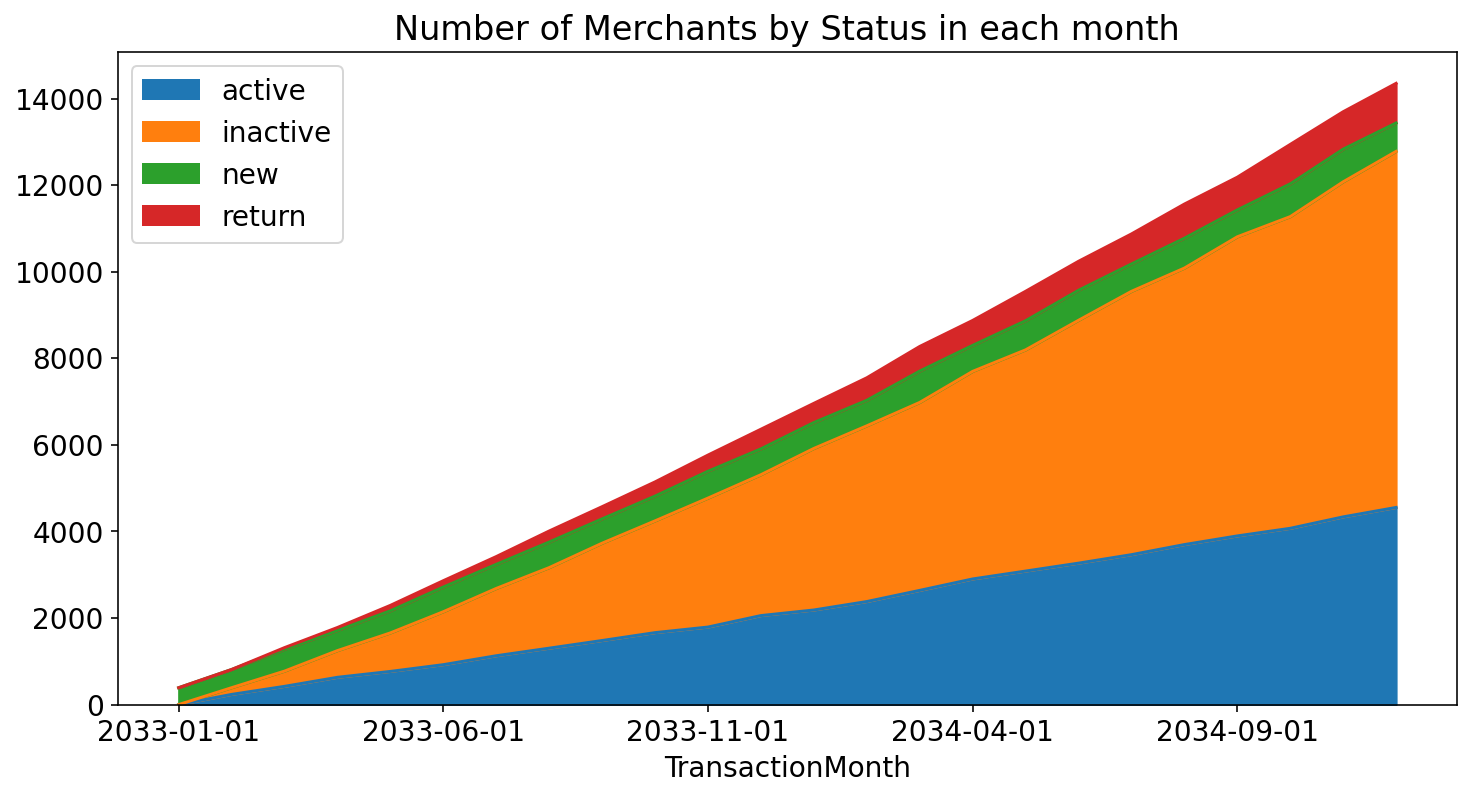

In [145]:
ax = month_status_pivot.plot.area(figsize = (12,6))
plt.title("Number of Merchants by Status in each month")
plt.show()

# Question 2: Identifying and Predicting the Churn Merchant

- Sometimes a merchant may stop processing with our payment service, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

## Definition of Churn

- RelRecency < 25% => score of 1
- RelFrequency < 25% => score of 1
- RelMonetaryValue < 25% => score of 1

In [149]:
df_mcht_churn = df_mcht.copy()
df_mcht_churn.loc[:, 'churn'] = 0
df_mcht_churn.loc[df_mcht_churn.RelRFM == 3, 'churn'] = 1

**Highlight**

The merchants that are considered to have already churned are shown in the next cells as below:

In [150]:
df_mcht_churn[df_mcht_churn.churn == 1]

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RelRecencyScore,RelFrequencyScore,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn
merchant,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,1,1,1,3,False,False,False,04. potential churn,1
000bcff341,7826,2033-08-09,2033-08-09,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,1,1,1,3,False,False,False,04. potential churn,1
000ddbf0ca,10299,2033-06-02,2033-06-02,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,1,1,1,3,False,False,False,04. potential churn,1
001f7b7a4f,6444,2034-03-02,2034-03-02,1,2034-03-01,304.0,304.0,0.000000,0.003289,21.197368,1,1,1,3,False,False,False,04. potential churn,1
0052daeb66,17393,2033-07-29,2033-07-22,2,2033-07-01,520.0,527.0,0.013283,0.003795,33.003795,1,1,1,3,False,False,False,04. potential churn,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff98eee16c,48041,2034-02-09,2034-02-09,1,2034-02-01,325.0,325.0,0.000000,0.003077,147.818462,1,1,1,3,False,False,False,04. potential churn,1
ffaeb2e3ce,5344,2033-03-19,2033-03-19,1,2033-03-01,652.0,652.0,0.000000,0.001534,8.196319,1,1,1,3,False,False,False,04. potential churn,1
ffc06f74ff,10235,2034-07-25,2034-07-18,2,2034-07-01,159.0,166.0,0.042169,0.012048,61.656627,1,1,1,3,False,False,False,04. potential churn,1


In [151]:
df_mcht.columns

Index(['MonetaryValue', 'LastTransactionDate', 'FirstTransactionDate',
       'Frequency', 'FirstTransactionMonth', 'Recency', 'Lifetime',
       'RelRecency', 'RelFrequency', 'RelMonetaryValue', 'RelRecencyScore',
       'RelFrequencyScore', 'RelMonetaryScore', 'RelRFM',
       'order_more_than_3_5pcnt', 'value_higher_than_700',
       'last_order_within_2_3', 'FinalRFM'],
      dtype='object')

In [152]:
requiredCol = ['FirstTransactionDate', 'LastTransactionDate', 'Lifetime', 
               'RelRecency', 'RelFrequency', 'RelMonetaryValue', "churn"
               # to avoid data snooping!
#                'order_more_than_3_5pcnt', 'value_higher_than_700', 'last_order_within_2_3', 
#                'FinalRFM'
              ]

df_mcht_churn = df_mcht_churn[requiredCol]

In [153]:
# df_mcht_churn.head()
df_mcht_churn

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,churn
merchant,,,,,,,
0002b63b92,2033-05-16,2033-05-16,594.0,0.000000,0.001684,5.688552,1
0002d07bba,2034-10-11,2034-12-15,81.0,0.802469,0.049383,1102.197531,0
00057d4302,2033-05-30,2033-08-04,580.0,0.113793,0.003448,50.898276,0
000bcff341,2033-08-09,2033-08-09,509.0,0.000000,0.001965,15.375246,1
000ddbf0ca,2033-06-02,2033-06-02,577.0,0.000000,0.001733,17.849220,1
...,...,...,...,...,...,...,...
ffd3e45675,2033-01-04,2033-01-27,726.0,0.031680,0.006887,100.035813,1
ffe1f6b51a,2033-06-04,2034-02-19,575.0,0.452174,0.081739,489.766957,0
ffe26b900d,2033-12-22,2034-11-21,374.0,0.893048,0.176471,2564.473262,0


In [154]:
# find out merchants that are not churn for the third sub-question we like to answer: 
# a model to predict which active merchants are most likely to churn in the near future.

df_mcht_churn_active = df_mcht_churn[df_mcht_churn.churn == 0]
df_mcht_churn_active

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,churn
merchant,,,,,,,
0002d07bba,2034-10-11,2034-12-15,81.0,0.802469,0.049383,1102.197531,0
00057d4302,2033-05-30,2033-08-04,580.0,0.113793,0.003448,50.898276,0
000ed1585f,2033-02-18,2034-12-06,681.0,0.963289,0.085169,2418.894273,0
000f8c3297,2033-09-29,2034-12-30,458.0,0.997817,0.323144,7544.085153,0
0020aefbd9,2034-05-30,2034-06-22,215.0,0.106977,0.009302,60.483721,0
...,...,...,...,...,...,...,...
ffc99ae470,2033-12-27,2034-12-26,369.0,0.986450,0.070461,2392.704607,0
ffd3284f86,2034-12-17,2034-12-30,14.0,0.928571,0.428571,5756.142857,0
ffe1f6b51a,2033-06-04,2034-02-19,575.0,0.452174,0.081739,489.766957,0


**Data Preprocessing**

In [185]:
df_X = df_mcht_churn.iloc[:,:-1]
df_X.head()

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
0002b63b92,2033-05-16,2033-05-16,594.0,0.000000,0.001684,5.688552
0002d07bba,2034-10-11,2034-12-15,81.0,0.802469,0.049383,1102.197531
00057d4302,2033-05-30,2033-08-04,580.0,0.113793,0.003448,50.898276
000bcff341,2033-08-09,2033-08-09,509.0,0.000000,0.001965,15.375246
000ddbf0ca,2033-06-02,2033-06-02,577.0,0.000000,0.001733,17.849220


In [186]:
df_X_active = df_mcht_churn_active.iloc[:, :-1]
df_X_active

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
0002d07bba,2034-10-11,2034-12-15,81.0,0.802469,0.049383,1102.197531
00057d4302,2033-05-30,2033-08-04,580.0,0.113793,0.003448,50.898276
000ed1585f,2033-02-18,2034-12-06,681.0,0.963289,0.085169,2418.894273
000f8c3297,2033-09-29,2034-12-30,458.0,0.997817,0.323144,7544.085153
0020aefbd9,2034-05-30,2034-06-22,215.0,0.106977,0.009302,60.483721
...,...,...,...,...,...,...
ffc99ae470,2033-12-27,2034-12-26,369.0,0.986450,0.070461,2392.704607
ffd3284f86,2034-12-17,2034-12-30,14.0,0.928571,0.428571,5756.142857
ffe1f6b51a,2033-06-04,2034-02-19,575.0,0.452174,0.081739,489.766957


In [191]:
# df_X['FirstTransactionDate'] = df_X.FirstTransactionDate.dt.to_period('D').astype(int) - 23010
# df_X['LastTransactionDate'] = df_X.LastTransactionDate.dt.to_period('D').astype(int) - 23010

In [189]:
firstDay = df_mcht.FirstTransactionDate.min()

In [192]:
df_X['FirstTransactionDate'] = (df_X.FirstTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days
df_X['LastTransactionDate'] = (df_X.LastTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days

In [166]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14351 entries, 0002b63b92 to fff1754102
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FirstTransactionDate  14351 non-null  int64  
 1   LastTransactionDate   14351 non-null  int64  
 2   Lifetime              14351 non-null  float64
 3   RelRecency            14351 non-null  float64
 4   RelFrequency          14351 non-null  float64
 5   RelMonetaryValue      14351 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3+ MB


In [193]:
df_X

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
0002b63b92,135,135,594.0,0.000000,0.001684,5.688552
0002d07bba,648,713,81.0,0.802469,0.049383,1102.197531
00057d4302,149,215,580.0,0.113793,0.003448,50.898276
000bcff341,220,220,509.0,0.000000,0.001965,15.375246
000ddbf0ca,152,152,577.0,0.000000,0.001733,17.849220
...,...,...,...,...,...,...
ffd3e45675,3,26,726.0,0.031680,0.006887,100.035813
ffe1f6b51a,154,414,575.0,0.452174,0.081739,489.766957
ffe26b900d,355,689,374.0,0.893048,0.176471,2564.473262


In [170]:
# df_X_active['FirstTransactionDate'] = df_X_active.FirstTransactionDate.dt.to_period('D').astype(int) - 23010
# df_X_active['LastTransactionDate'] = df_X_active.LastTransactionDate.dt.to_period('D').astype(int) - 23010

/var/folders/2t/5fzjt2x13h329_bxg11ttqzh0000gn/T/ipykernel_5479/3544048726.py:1: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_X_active['FirstTransactionDate'] = df_X_active.FirstTransactionDate.dt.to_period('D').astype(int) - 23010
/var/folders/2t/5fzjt2x13h329_bxg11ttqzh0000gn/T/ipykernel_5479/3544048726.py:2: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_X_active['LastTransactionDate'] = df_X_active.LastTransactionDate.dt.to_period('D').astype(int) - 23010


In [194]:
df_X_active['FirstTransactionDate'] = (df_X_active.FirstTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days
df_X_active['LastTransactionDate'] = (df_X_active.LastTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days

In [195]:
df_X_active

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
0002d07bba,648,713,81.0,0.802469,0.049383,1102.197531
00057d4302,149,215,580.0,0.113793,0.003448,50.898276
000ed1585f,48,704,681.0,0.963289,0.085169,2418.894273
000f8c3297,271,728,458.0,0.997817,0.323144,7544.085153
0020aefbd9,514,537,215.0,0.106977,0.009302,60.483721
...,...,...,...,...,...,...
ffc99ae470,360,724,369.0,0.986450,0.070461,2392.704607
ffd3284f86,715,728,14.0,0.928571,0.428571,5756.142857
ffe1f6b51a,154,414,575.0,0.452174,0.081739,489.766957


In [196]:
df_y = df_mcht_churn.loc[:, ['churn']]
df_y.head()

,churn
merchant,
0002b63b92,1
0002d07bba,0
00057d4302,0
000bcff341,1
000ddbf0ca,1


### Data Split

- The entire dataset, including all churned and non-churned merchants, are split into 3 categories, training, testing, and validation.

- The non-churned merchants (12.8K out of the entire dataset, 14.3K) will be applied as a testing dataset to predict the potential churn.
    - concerns: the training data already includes large parts of the dataset to be predicted (df_X_active), which might lead to overfitting. The performance might not be generalized enough.
        - Apply **updated version** for this

In [221]:
X = np.asanyarray(df_X)
y = np.asanyarray(df_y)
X_active = np.asanyarray(df_X_active)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train_htune, X_val_htune, y_train_htune, y_val_htune = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

print ("Training dataset shape of X, Y: ", X_train.shape, y_train.shape)
print ("Testing dataset shape of X, Y: ", X_test.shape, y_test.shape)

print ("Training dataset for hyper parameter tuning shape of X, Y: ", X_train_htune.shape, y_train_htune.shape)
print ("Validation dataset for hyper parameter tuning shape of X, Y: ", X_val_htune.shape, y_val_htune.shape)

Training dataset shape of X, Y:  (11480, 6) (11480, 1)
Testing dataset shape of X, Y:  (2871, 6) (2871, 1)
Training dataset for hyper parameter tuning shape of X, Y:  (9184, 6) (9184, 1)
Validation dataset for hyper parameter tuning shape of X, Y:  (2296, 6) (2296, 1)


## Options of Model for Predicting which Active Merchants are most likely to Churn in the near future

- Logistics Regression
- Decision Tree

In [217]:
# baseline through shuffling

y_pred_base = y_test.copy()
np.random.shuffle(y_pred_base)

print ("Testing Accuracy for baseline model (random guess) is {:.3f}".format(accuracy_score(y_test, y_pred_base))) # ori: 0.815

Testing Accuracy for baseline model (random guess) is 0.816


In [224]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train.ravel())

y_pred_lr = model_lr.predict(X_test)
    
print ("Testing Accuracy for logistic regression is {:.3f}".format(accuracy_score(y_test, y_pred_lr))) # ori: 0.980

Testing Accuracy for logistic regression is 0.979


In [225]:
model_lr.fit(X, y.ravel())
y_active_pred = model_lr.predict(X_active)

**Highlight**

Logistic Regression's answer on which merchants are likely to churn in the near future.

In [202]:
df_X_active[y_active_pred == 1] # ori: 173

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
00ef1ec165,704,704,25.0,0.000000,0.040000,30.080000
01741912b7,443,449,286.0,0.020979,0.013986,84.860140
035a9fe0e1,709,709,20.0,0.000000,0.050000,43.650000
03f2100e21,664,664,65.0,0.000000,0.015385,13.646154
06d30e9933,126,136,603.0,0.016584,0.016584,103.150912
...,...,...,...,...,...,...
f432ba459e,647,647,82.0,0.000000,0.012195,63.475610
f4479adb56,25,25,704.0,0.000000,0.001420,279.590909
f640587c93,515,519,214.0,0.018692,0.014019,103.859813


**Decision Tree**

In [226]:
model_tree = DecisionTreeClassifier(max_depth=3, random_state=0)
model_tree.fit(X_train, y_train.ravel())
y_pred_tree = model_tree.predict(X_test)

print ("Testing Accuracy for decision tree is {:.3f}".format(accuracy_score(y_test, y_pred_tree))) # ori: 0.992

Testing Accuracy for decision tree is 0.992


**Visualization of Decision Tree Judgement Flow**

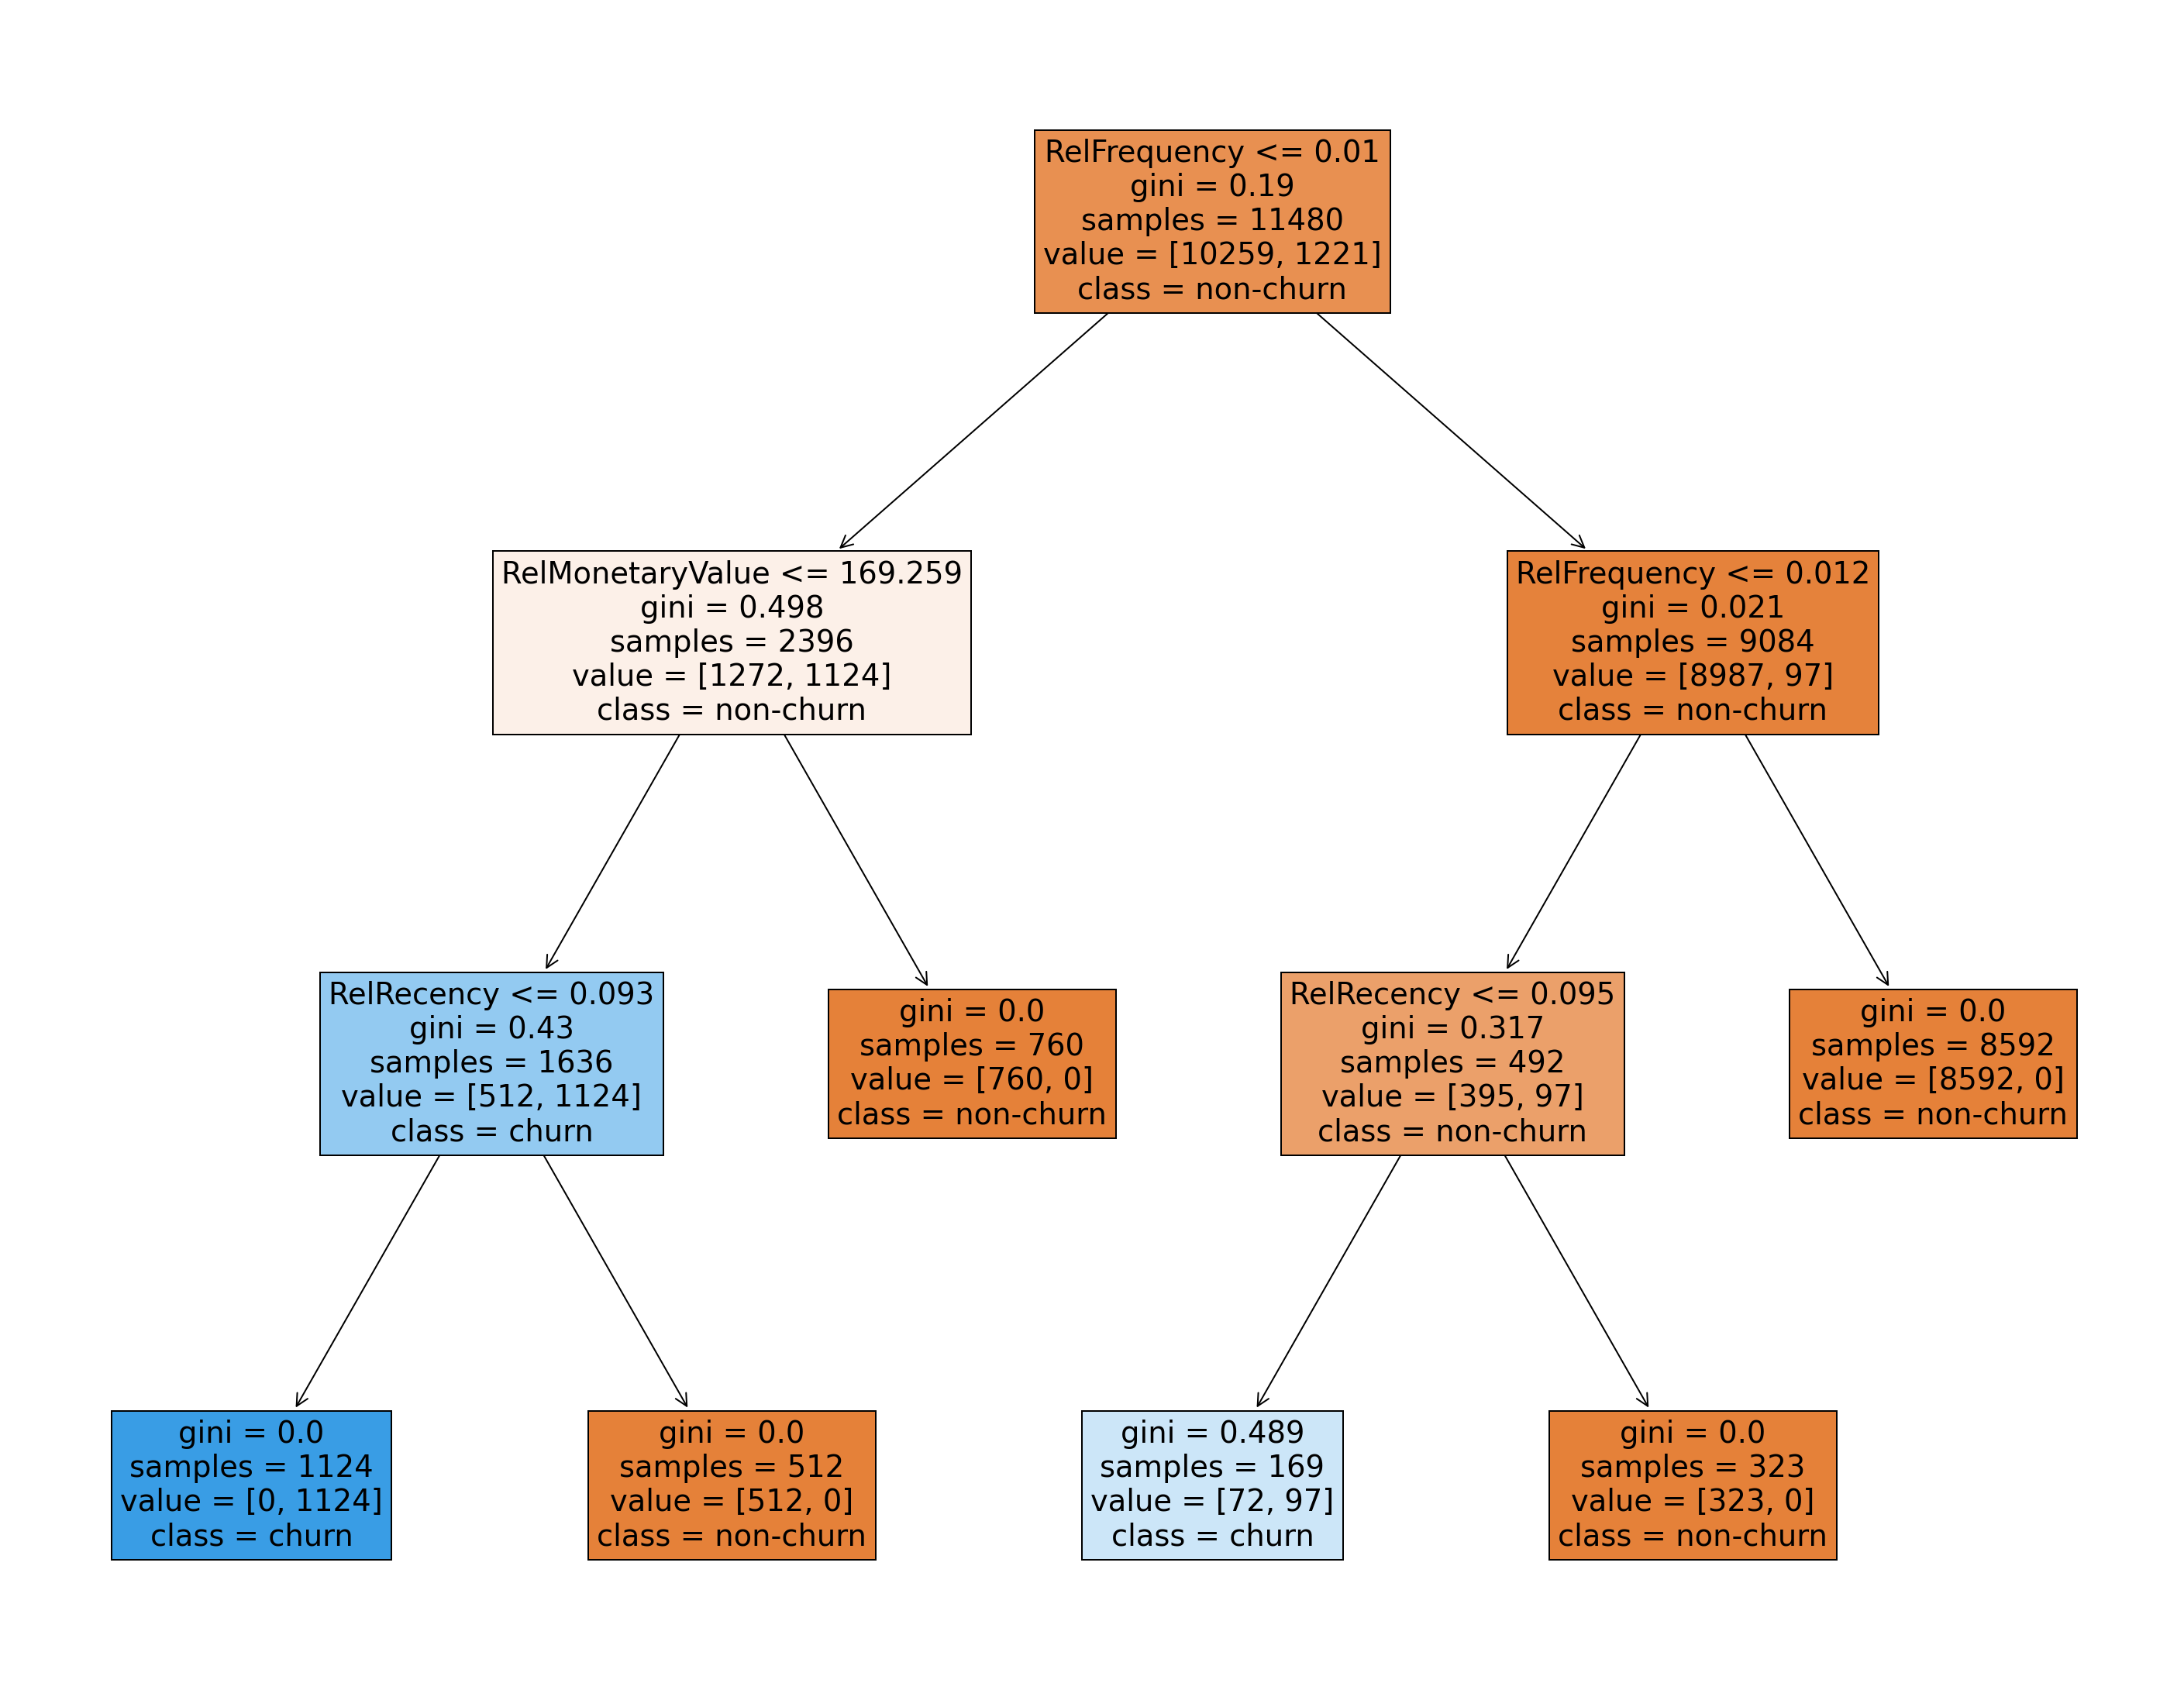

In [204]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_tree, 
                   feature_names=df_X_active.columns,  
                   class_names= ['non-churn', 'churn'],
                   filled=True)

In [205]:
model_tree.fit(X, y)
y_active_pred = model_tree.predict(X_active)

**Highlight**

Decision Tree's answer on which merchants are likely to churn in the near future.

In [206]:
df_X_active[y_active_pred == 1] # ori: 102

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
014d46a7cd,625,625,104.0,0.000000,0.009615,274.096154
02ec54dace,638,638,91.0,0.000000,0.010989,198.054945
039c0136d4,646,646,83.0,0.000000,0.012048,973.698795
04056f3ad9,635,635,94.0,0.000000,0.010638,1139.393617
04a9a88e94,519,520,210.0,0.004762,0.009524,230.323810
...,...,...,...,...,...,...
fabb7a0b0a,563,566,166.0,0.018072,0.012048,195.427711
fb75c0c3a4,528,530,201.0,0.009950,0.009950,10645.223881
fe105bb2db,637,637,92.0,0.000000,0.010870,294.847826


## Updated Version: applying self-supermised machine learning for the issues



- Sometimes a merchant may stop processing with our payment service, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

## Definition 

**Churn**
- RelRecency < 25% => score of 1
- RelFrequency < 25% => score of 1
- RelMonetaryValue < 25% => score of 1

**Non-churn**
- RelRecency > 75% => score of 4
- RelFrequency > 75% => score of 4
- RelMonetaryValue > 75% => score of 4

**Unknown**
- All remaining observations(merchants) after above.

In [283]:
df_mcht_churn2 =df_mcht.copy()

In [284]:
df_mcht_churn2.columns

Index(['MonetaryValue', 'LastTransactionDate', 'FirstTransactionDate',
       'Frequency', 'FirstTransactionMonth', 'Recency', 'Lifetime',
       'RelRecency', 'RelFrequency', 'RelMonetaryValue', 'RelRecencyScore',
       'RelFrequencyScore', 'RelMonetaryScore', 'RelRFM',
       'order_more_than_3_5pcnt', 'value_higher_than_700',
       'last_order_within_2_3', 'FinalRFM'],
      dtype='object')

In [285]:
df_mcht_churn2['churn'] = np.where(df_mcht_churn2['RelRFM'] == 3, 1, -1)
df_mcht_churn2['churn'] = np.where(df_mcht_churn2['RelRFM'] == 12, 0, df_mcht_churn2['churn'])

df_mcht_churn2.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RelRecencyScore,RelFrequencyScore,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn
merchant,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,2033-05-16,2033-05-16,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,1,1,1,3,False,False,False,04. potential churn,1
0002d07bba,89278,2034-12-15,2034-10-11,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,3,3,3,9,True,True,True,01. high engagement and high value,-1
00057d4302,29521,2033-08-04,2033-05-30,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,2,1,1,4,False,False,False,04. potential churn,-1
000bcff341,7826,2033-08-09,2033-08-09,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,1,1,1,3,False,False,False,04. potential churn,1
000ddbf0ca,10299,2033-06-02,2033-06-02,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,1,1,1,3,False,False,False,04. potential churn,1


In [286]:
df_mcht_churn2.loc[:, 'FirstTransactionDate'] = (df_mcht_churn2.FirstTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days
df_mcht_churn2.loc[:, 'LastTransactionDate'] = (df_mcht_churn2.LastTransactionDate.astype(str).apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - firstDay).dt.days
df_mcht_churn2.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RelRecencyScore,RelFrequencyScore,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn
merchant,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,135,135,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,1,1,1,3,False,False,False,04. potential churn,1
0002d07bba,89278,713,648,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,3,3,3,9,True,True,True,01. high engagement and high value,-1
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,2,1,1,4,False,False,False,04. potential churn,-1
000bcff341,7826,220,220,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,1,1,1,3,False,False,False,04. potential churn,1
000ddbf0ca,10299,152,152,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,1,1,1,3,False,False,False,04. potential churn,1


In [287]:
requiredCol = ['FirstTransactionDate', 'LastTransactionDate', 'Lifetime', 
               'RelRecency', 'RelFrequency', 'RelMonetaryValue', "churn"
               # to avoid data snooping!
#                'order_more_than_3_5pcnt', 'value_higher_than_700', 'last_order_within_2_3', 
#                'FinalRFM'
              ]

df_mcht_churn2_m = df_mcht_churn2[requiredCol]
df_mcht_churn2_m.head()

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,churn
merchant,,,,,,,
0002b63b92,135,135,594.0,0.000000,0.001684,5.688552,1
0002d07bba,648,713,81.0,0.802469,0.049383,1102.197531,-1
00057d4302,149,215,580.0,0.113793,0.003448,50.898276,-1
000bcff341,220,220,509.0,0.000000,0.001965,15.375246,1
000ddbf0ca,152,152,577.0,0.000000,0.001733,17.849220,1


In [288]:
df_X2 = df_mcht_churn2_m.iloc[:, :-1]
df_X2.head()

,FirstTransactionDate,LastTransactionDate,Lifetime,RelRecency,RelFrequency,RelMonetaryValue
merchant,,,,,,
0002b63b92,135,135,594.0,0.000000,0.001684,5.688552
0002d07bba,648,713,81.0,0.802469,0.049383,1102.197531
00057d4302,149,215,580.0,0.113793,0.003448,50.898276
000bcff341,220,220,509.0,0.000000,0.001965,15.375246
000ddbf0ca,152,152,577.0,0.000000,0.001733,17.849220


In [289]:
df_y2 = df_mcht_churn2_m.iloc[:,-1]
df_y2.head()

merchant
0002b63b92    1
0002d07bba   -1
00057d4302   -1
000bcff341    1
000ddbf0ca    1
Name: churn, dtype: int64

In [290]:
X2 = np.asanyarray(df_X2)
y2 = np.asanyarray(df_y2)

In [291]:
X2.shape
y2.shape

(14351,)

### Model 1:  SelfTrainingClassifier

In [356]:
model_lr = LogisticRegression()
self_training_model = SelfTrainingClassifier(model_lr)
self_training_model.fit(X2, y2)

/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelfTrainingClassifier(base_estimator=LogisticRegression())

In [357]:
sum(self_training_model.transduction_ == -1) # 5

5

In [358]:
df_mcht_churn2['churn_SelfTraining'] = self_training_model.transduction_
df_mcht_churn2.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,135,135,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,...,1,3,False,False,False,04. potential churn,1,1,1,1
0002d07bba,89278,713,648,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,...,3,9,True,True,True,01. high engagement and high value,-1,1,0,0
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,...,1,4,False,False,False,04. potential churn,-1,1,0,0
000bcff341,7826,220,220,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,...,1,3,False,False,False,04. potential churn,1,1,1,1
000ddbf0ca,10299,152,152,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,...,1,3,False,False,False,04. potential churn,1,1,1,1


In [359]:
sum(df_mcht_churn2.churn_SelfTraining == 1)

9356

In [365]:
df_mcht_churn2[(df_mcht_churn2.churn_SelfTraining == 1) & (df_mcht_churn2.RelRFM <=6)]


,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,135,135,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,...,1,3,False,False,False,04. potential churn,1,1,1,1
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,...,1,4,False,False,False,04. potential churn,-1,1,0,0
000bcff341,7826,220,220,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,...,1,3,False,False,False,04. potential churn,1,1,1,1
000ddbf0ca,10299,152,152,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,...,1,3,False,False,False,04. potential churn,1,1,1,1
001f7b7a4f,6444,425,425,1,2034-03-01,304.0,304.0,0.000000,0.003289,21.197368,...,1,3,False,False,False,04. potential churn,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffaeb2e3ce,5344,77,77,1,2033-03-01,652.0,652.0,0.000000,0.001534,8.196319,...,1,3,False,False,False,04. potential churn,1,1,1,1
ffc06f74ff,10235,570,563,2,2034-07-01,159.0,166.0,0.042169,0.012048,61.656627,...,1,3,False,False,False,04. potential churn,1,1,1,1
ffc46fd720,20058,524,454,6,2034-03-01,205.0,275.0,0.254545,0.021818,72.938182,...,1,5,False,False,False,04. potential churn,-1,1,0,0


In [371]:
df_mcht_churn2[(df_mcht_churn2.churn_SelfTraining == 1) & (df_mcht_churn2.RelMonetaryScore <=2) & (df_mcht_churn2.RelFrequencyScore <=2) & (df_mcht_churn2.RelRecencyScore <=2) & (df_mcht_churn2.RelRFM != 3)]


,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,...,1,4,False,False,False,04. potential churn,-1,1,0,0
0020aefbd9,13004,537,514,2,2034-05-01,192.0,215.0,0.106977,0.009302,60.483721,...,1,4,False,False,False,04. potential churn,-1,1,0,0
0026f256ac,250878,257,168,8,2033-06-01,472.0,561.0,0.158645,0.014260,447.197861,...,2,6,False,False,False,04. potential churn,-1,1,0,0
0047f556b5,212026,351,305,3,2033-11-01,378.0,424.0,0.108491,0.007075,500.061321,...,2,5,False,False,False,04. potential churn,-1,1,0,0
005c218139,11160,605,595,3,2034-08-01,124.0,134.0,0.074627,0.022388,83.283582,...,1,4,False,False,False,04. potential churn,-1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff7fdd71a0,26952,675,604,3,2034-08-01,54.0,125.0,0.568000,0.024000,215.616000,...,2,6,False,False,False,04. potential churn,-1,1,0,0
ff8f964b25,59559,504,182,16,2033-07-01,225.0,547.0,0.588665,0.029250,108.882998,...,1,5,False,False,False,04. potential churn,-1,1,0,0
ff9135ed50,18824,698,698,1,2034-11-01,31.0,31.0,0.000000,0.032258,607.225806,...,2,5,False,False,False,04. potential churn,-1,1,0,0


In [361]:
print ("Probability of identification as churn based on RelRFM score")

for relrfm in range(4, 12):
    prob = sum(df_mcht_churn2['churn_SelfTraining'][df_mcht_churn2.RelRFM == relrfm])/len(df_mcht_churn2)
    print ("RelRFM score: ", relrfm, " churn prob: ", prob)
    print ()

Probability of identification as churn based on RelRFM score
RelRFM score:  4  churn prob:  0.09170092676468539

RelRFM score:  5  churn prob:  0.09636959096927043

RelRFM score:  6  churn prob:  0.08577799456483869

RelRFM score:  7  churn prob:  0.09072538499059299

RelRFM score:  8  churn prob:  0.07623162148979165

RelRFM score:  9  churn prob:  0.05470002090446659

RelRFM score:  10  churn prob:  0.03344714654031078

RelRFM score:  11  churn prob:  0.016932617936032332



In [370]:
print ("Average RelRecency for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_SelfTraining == 1) & (df_mcht_churn2.RelMonetaryScore <=2) & (df_mcht_churn2.RelFrequencyScore <=2) & (df_mcht_churn2.RelRecencyScore <=2)].RelRecency))
print ("Average RelFrequency for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_SelfTraining == 1) & (df_mcht_churn2.RelMonetaryScore <=2) & (df_mcht_churn2.RelFrequencyScore <=2) & (df_mcht_churn2.RelRecencyScore <=2)].RelFrequency))
print ("Average RelMonetaryValue for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_SelfTraining == 1) & (df_mcht_churn2.RelMonetaryScore <=2) & (df_mcht_churn2.RelFrequencyScore <=2) & (df_mcht_churn2.RelRecencyScore <=2)].RelMonetaryValue))

Average RelRecency for potential churn merchants 0.14165384361619449
Average RelFrequency for potential churn merchants 0.011315164099007999
Average RelMonetaryValue for potential churn merchants 166.75729578846835


### Model 2: LabelPropagation

In [296]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X2, y2)

LabelPropagation()

In [297]:
sum(label_prop_model.transduction_ == -1) # 0

0

In [298]:
df_mcht_churn2['churn_LabelPropagation'] = label_prop_model.transduction_
df_mcht_churn2.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelFrequencyScore,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,135,135,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,...,1,1,3,False,False,False,04. potential churn,1,1,1
0002d07bba,89278,713,648,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,...,3,3,9,True,True,True,01. high engagement and high value,-1,1,0
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,...,1,1,4,False,False,False,04. potential churn,-1,1,0
000bcff341,7826,220,220,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,...,1,1,3,False,False,False,04. potential churn,1,1,1
000ddbf0ca,10299,152,152,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,...,1,1,3,False,False,False,04. potential churn,1,1,1


In [299]:
sum(df_mcht_churn2.churn_LabelPropagation == 1)

1560

In [319]:
df_mcht_churn2[(df_mcht_churn2.churn_LabelPropagation == 1) & (df_mcht_churn2.RelRFM !=3)]

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
09cd9bce5c,7431,607,604,2,2034-08-01,122.0,125.0,0.024000,0.016000,59.448000,...,1,4,False,False,False,04. potential churn,-1,1,1,1
11db110579,8377,627,622,2,2034-09-01,102.0,107.0,0.046729,0.018692,78.289720,...,1,4,False,False,False,04. potential churn,-1,1,1,1
1eb227a30c,9131,633,629,2,2034-09-01,96.0,100.0,0.040000,0.020000,91.310000,...,1,4,False,False,False,04. potential churn,-1,1,1,1
212aedbe72,16255,578,577,2,2034-08-01,151.0,152.0,0.006579,0.013158,106.940789,...,1,4,False,False,False,04. potential churn,-1,1,1,1
2c39b43877,19110,541,537,3,2034-06-01,188.0,192.0,0.020833,0.015625,99.531250,...,1,4,False,False,False,04. potential churn,-1,1,1,1
30ae722c1a,18654,566,564,2,2034-07-01,163.0,165.0,0.012121,0.012121,113.054545,...,1,4,False,False,False,04. potential churn,-1,1,1,1
31f3080baa,28361,540,536,3,2034-06-01,189.0,193.0,0.020725,0.015544,146.948187,...,1,4,False,False,False,04. potential churn,-1,1,1,1
3339c44baa,15106,506,495,3,2034-05-01,223.0,234.0,0.047009,0.012821,64.555556,...,1,4,False,False,False,04. potential churn,-1,1,1,1
33d228c5c9,6906,640,639,2,2034-10-01,89.0,90.0,0.011111,0.022222,76.733333,...,1,4,False,False,False,04. potential churn,-1,1,1,1


In [301]:
df_mcht_churn2[['RelRFM', 'churn', 'churn_LabelPropagation']].head()

,RelRFM,churn,churn_LabelPropagation
merchant,,,
0002b63b92,3,1,1
0002d07bba,9,-1,0
00057d4302,4,-1,0
000bcff341,3,1,1
000ddbf0ca,3,1,1


In [310]:
print ("Probability of identification as churn based on RelRFM score")

for relrfm in range(4, 12):
    prob = sum(df_mcht_churn2['churn_LabelPropagation'][df_mcht_churn2.RelRFM == relrfm])/len(df_mcht_churn2)
    print ("RelRFM score: ", relrfm, " churn prob: ", prob)
    print ()

Probability of identification as churn based on RelRFM score
RelRFM score:  4  churn prob:  0.002926625322277193

RelRFM score:  5  churn prob:  6.968155529231412e-05

RelRFM score:  6  churn prob:  0.0

RelRFM score:  7  churn prob:  0.0

RelRFM score:  8  churn prob:  0.0

RelRFM score:  9  churn prob:  0.0

RelRFM score:  10  churn prob:  0.0

RelRFM score:  11  churn prob:  0.0



### Model 3: LabelSpreading

In [312]:
label_spread_model = LabelSpreading()
label_spread_model.fit(X2, y2)

LabelSpreading()

In [313]:
sum(label_spread_model.transduction_ == -1) # 0

0

In [314]:
df_mcht_churn2['churn_LabelSpreading'] = label_spread_model.transduction_
df_mcht_churn2.head()

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
0002b63b92,3379,135,135,1,2033-05-01,594.0,594.0,0.000000,0.001684,5.688552,...,1,3,False,False,False,04. potential churn,1,1,1,1
0002d07bba,89278,713,648,4,2034-10-01,16.0,81.0,0.802469,0.049383,1102.197531,...,3,9,True,True,True,01. high engagement and high value,-1,1,0,0
00057d4302,29521,215,149,2,2033-05-01,514.0,580.0,0.113793,0.003448,50.898276,...,1,4,False,False,False,04. potential churn,-1,1,0,0
000bcff341,7826,220,220,1,2033-08-01,509.0,509.0,0.000000,0.001965,15.375246,...,1,3,False,False,False,04. potential churn,1,1,1,1
000ddbf0ca,10299,152,152,1,2033-06-01,577.0,577.0,0.000000,0.001733,17.849220,...,1,3,False,False,False,04. potential churn,1,1,1,1


In [315]:
sum(df_mcht_churn2.churn_LabelSpreading == 1)

1559

In [318]:
df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)]

,MonetaryValue,LastTransactionDate,FirstTransactionDate,Frequency,FirstTransactionMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,...,RelMonetaryScore,RelRFM,order_more_than_3_5pcnt,value_higher_than_700,last_order_within_2_3,FinalRFM,churn,churn_SelfTraining,churn_LabelPropagation,churn_LabelSpreading
merchant,,,,,,,,,,,,,,,,,,,,,
09cd9bce5c,7431,607,604,2,2034-08-01,122.0,125.0,0.024000,0.016000,59.448000,...,1,4,False,False,False,04. potential churn,-1,1,1,1
11db110579,8377,627,622,2,2034-09-01,102.0,107.0,0.046729,0.018692,78.289720,...,1,4,False,False,False,04. potential churn,-1,1,1,1
1eb227a30c,9131,633,629,2,2034-09-01,96.0,100.0,0.040000,0.020000,91.310000,...,1,4,False,False,False,04. potential churn,-1,1,1,1
212aedbe72,16255,578,577,2,2034-08-01,151.0,152.0,0.006579,0.013158,106.940789,...,1,4,False,False,False,04. potential churn,-1,1,1,1
2c39b43877,19110,541,537,3,2034-06-01,188.0,192.0,0.020833,0.015625,99.531250,...,1,4,False,False,False,04. potential churn,-1,1,1,1
30ae722c1a,18654,566,564,2,2034-07-01,163.0,165.0,0.012121,0.012121,113.054545,...,1,4,False,False,False,04. potential churn,-1,1,1,1
31f3080baa,28361,540,536,3,2034-06-01,189.0,193.0,0.020725,0.015544,146.948187,...,1,4,False,False,False,04. potential churn,-1,1,1,1
3339c44baa,15106,506,495,3,2034-05-01,223.0,234.0,0.047009,0.012821,64.555556,...,1,4,False,False,False,04. potential churn,-1,1,1,1
33d228c5c9,6906,640,639,2,2034-10-01,89.0,90.0,0.011111,0.022222,76.733333,...,1,4,False,False,False,04. potential churn,-1,1,1,1


In [316]:
df_mcht_churn2[['RelRFM', 'churn', 'churn_LabelSpreading']].head()

,RelRFM,churn,churn_LabelSpreading
merchant,,,
0002b63b92,3,1,1
0002d07bba,9,-1,0
00057d4302,4,-1,0
000bcff341,3,1,1
000ddbf0ca,3,1,1


In [317]:
print ("Probability of identification as churn based on RelRFM score")

for relrfm in range(4, 12):
    prob = sum(df_mcht_churn2['churn_LabelSpreading'][df_mcht_churn2.RelRFM == relrfm])/len(df_mcht_churn2)
    print ("RelRFM score: ", relrfm, " churn prob: ", prob)
    print ()

Probability of identification as churn based on RelRFM score
RelRFM score:  4  churn prob:  0.002856943766984879

RelRFM score:  5  churn prob:  6.968155529231412e-05

RelRFM score:  6  churn prob:  0.0

RelRFM score:  7  churn prob:  0.0

RelRFM score:  8  churn prob:  0.0

RelRFM score:  9  churn prob:  0.0

RelRFM score:  10  churn prob:  0.0

RelRFM score:  11  churn prob:  0.0



In [325]:
print ("Average RelRecency for potential churn merchants", np.mean(df_mcht_churn2[df_mcht_churn2.churn_LabelSpreading == 1].RelRecency))
print ("Average RelFrequency for potential churn merchants", np.mean(df_mcht_churn2[df_mcht_churn2.churn_LabelSpreading == 1].RelFrequency))
print ("Average RelMonetaryValue for potential churn merchants", np.mean(df_mcht_churn2[df_mcht_churn2.churn_LabelSpreading == 1].RelMonetaryValue))

Average RelRecency for potential churn merchants 0.01277656186162158
Average RelFrequency for potential churn merchants 0.00526419174993071
Average RelMonetaryValue for potential churn merchants 58.393884310802484


In [362]:
print ("Average RelRecency for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelRecency))
print ("Average RelFrequency for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelFrequency))
print ("Average RelMonetaryValue for potential churn merchants", np.mean(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelMonetaryValue))

Average RelRecency for potential churn merchants 0.026999459338287683
Average RelFrequency for potential churn merchants 0.01743454191102148
Average RelMonetaryValue for potential churn merchants 83.45074072065192


In [372]:
print ("Minimum RelRecency for potential churn merchants", np.min(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelRecency))
print ("Minimum RelFrequency for potential churn merchants", np.min(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelFrequency))
print ("Minimum RelMonetaryValue for potential churn merchants", np.min(df_mcht_churn2[(df_mcht_churn2.churn_LabelSpreading == 1) & (df_mcht_churn2.RelRFM !=3)].RelMonetaryValue))

Minimum RelRecency for potential churn merchants 0.0
Minimum RelFrequency for potential churn merchants 0.006896551724137931
Minimum RelMonetaryValue for potential churn merchants 3.0068965517241377
